# Исследование закономерностей успешности игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности для выделения потенциально популярного продукта и планирования рекламных кампаний.

План работы:

1) проведем предобработку данных;

2) проведем исследовательский анализ данных:
- выясним количество выпущенных игр по годам
- посмотрим на изменение продаж по платформам и опредилим время жизни платформы
- определим потенциально прибыльные платформы
- оценим зависимость влияния на продажи отзывов критиков и пользователей
- рассмотрим, игр каких жанров больше и меньше всего

3) составим портрет пользователя из каждого региона, выявив самые популярные жанры и платформы

4) проверим гипотезы:
- одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC
- разные ли средние пользовательские рейтинги жанров Action и Sports

##  Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
from scipy.stats import binom, norm
from math import sqrt

In [2]:
try:
    data_games = pd.read_csv('/datasets/games.csv')
except:
    data_games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
data_games.head(20)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<div style="border: solid pink 2px; padding: 20px">Таблица data_games состоит из 16715 строк, она содержит информацию о название игры, платформе, год выпуска, жанре игры, продажах в Северной Америке, Европе, Японии и других странах (миллионы проданных копий), оценке критиков (максимум 100),  оценке пользователей (максимум 10) и рейтинг от организации ESRB. Есть пропуски в столбцах c названием игры, годом выпуска, жанром, оценкой критиков, оценкой пользователей и рейтингом ESRB.

## Предобработка данных

In [5]:
data_games.columns = [col.lower() for col in data_games.columns] # приведение названия столбцов к нижнему регистру

In [6]:
data_games.columns  # проверка

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

In [7]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Процент пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось')

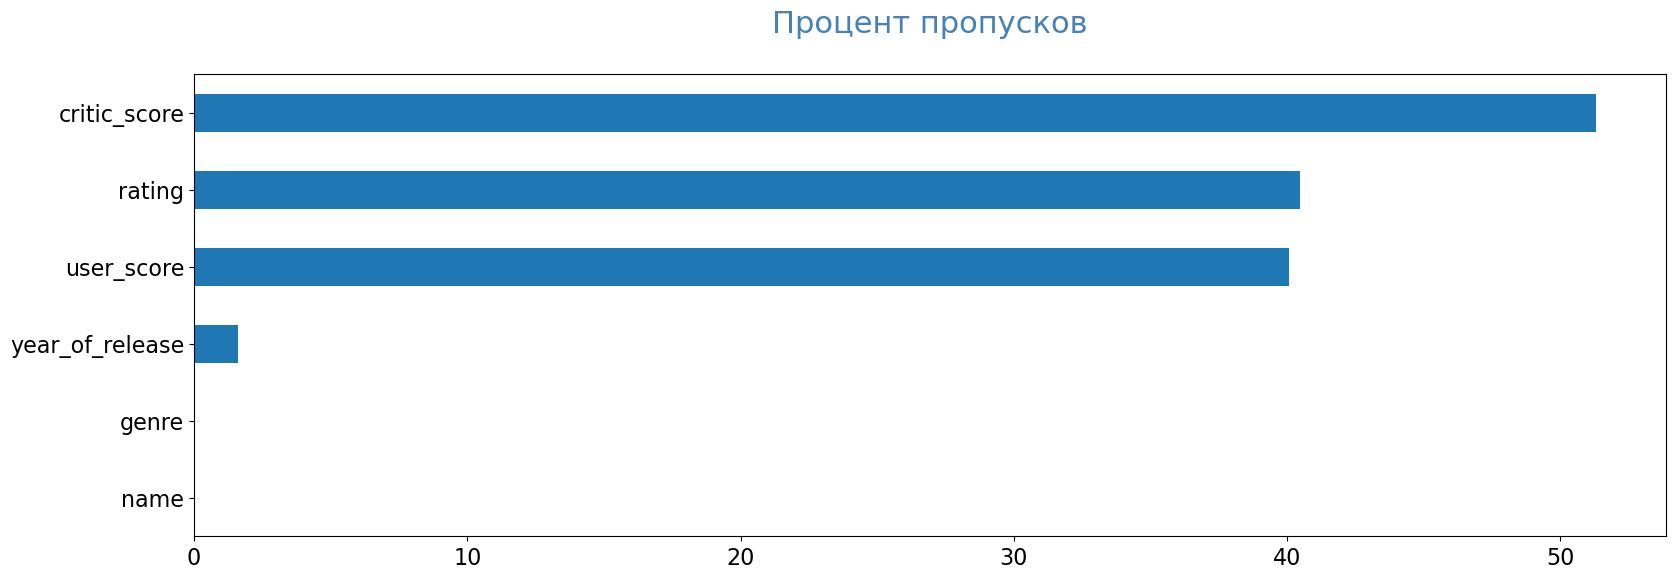

In [8]:
pass_value_barh(data_games)

В столбце critic_score больше половины пропусков, так же можно заметить близость процентов пропущенных значений в колонках rating и user_score, отвечающих за рейтинг от организации ESRB и оценку пользователей. Так же есть пропуски в колонке с годом выхода игры, а колонки genre и name содержат пропуски, поэтому отобразились на графике, однако их так мало, что не видно и процента.

#### Пропуски в столбцах genre и name

In [9]:
data_games[data_games['name'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всего две строки, удалим их

In [10]:
data_games = data_games[data_games['name'].notna()]

#### Пропуски в столбцах с оценками критиков и оценками пользователей

In [11]:
data_games[data_games['critic_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [12]:
data_games[data_games['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


Не все выходящие и вышедшие игры оцениваются критиками, так что пропуски нормальны. Так же стоит учесть, что для каждой игры на разных ресурсах может быть различная оценка, особенно если это разные регионы. Это относится и к оценкам пользователей. Перебирать все восемь тысяч игр и искать для каждой какую-то среднюю оценку кажется нерациональным.

[TBD](https://www.oxfordlearnersdictionaries.com/definition/english/tbd#:~:text=to%20be%20decided%2Fdetermined) - аббревиатура от английского To Be Decided (будет решено) или To Be Determined (будет определено). В контексте оценок критиков это означает, что общая оценка еще не выставлена. Для того, чтобы не потерять данные, можно заполнить пропуски в столбцах critic_score и user_score этой аббревиатурой.

In [13]:
data_games['critic_score'] = data_games['critic_score'].fillna('tbd')

In [14]:
data_games['critic_score'].isna().sum() # проверка

0

In [15]:
data_games['user_score'] = data_games['user_score'].fillna('tbd')

In [16]:
data_games['user_score'].isna().sum() # проверка

0

#### Пропуски в столбце с возрастным рейтингом от ESRB 

In [17]:
data_games[data_games['rating'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,tbd,tbd,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,tbd,tbd,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,tbd,tbd,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,tbd,tbd,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,tbd,tbd,NaN


Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. ESRB была основана в 1994 году. 
Из чего можно сделать вывод, что часть игр, вышедших до 1994 года могут не иметь рейтинга, а так же часть игр не имеет рейтинга, так как выпушенна в других странах, часть из которых не принимает оценку ESRB, а имеет какую-то свою.

In [18]:
data_games['rating'].unique() # проверим, нет ли аббревиатуры с верхним регистром и выясним, какие вообще присутствуют рейтинги

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Для понимания выясним, что стоит за каждым значением. Согласно [Ratings Guide](https://www.esrb.org/ratings-guide/):
- E «Для всех»: Содержание вполне подходит для всех возрастов. Первоначально "K-A" ("Kids to Adults").
- M «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.
- T «Подросткам»: Игра подходит для лиц от 13 лет. 
- E10+ «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.
- AO «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.
- EC «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими.
- RP «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. 

Пропуски в столбце можем заполнить значением RP, а рейтинг K-A заменить на Е.

In [19]:
data_games['rating'] = data_games['rating'].fillna('RP')

In [20]:
data_games['rating'].isna().sum() # проверка

0

In [21]:
data_games = data_games.replace(['K-A'],'E')

In [22]:
data_games['rating'].unique() # проверка

array(['E', 'RP', 'M', 'T', 'E10+', 'AO', 'EC'], dtype=object)

#### Пропуски в столбце с годом выпуска

In [23]:
data_games[data_games['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,tbd,tbd,RP
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,tbd,tbd,RP
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,tbd,tbd,RP


Пропуски в столбце с годом выпуска объяснить сложно, возможно они появились появились при добавлении данных по играм с ресурса, где не был указан год выпуска. Пропусков меньше 2%, заполнить их как-то, кроме как вручную, мы не можем. Для удобства преобразования данных удалим эти данные.

In [24]:
data_games = data_games.dropna(subset=['year_of_release'])

<div style="border: solid pink 2px; padding: 20px">В таблице большинство пропусков в столбцах с оценками от критиков и пользователей,а так же с возрастным рейтингом. Возможно стоит найти другие источники данных для заполнения этих пропусков и перепроверить использованные источники (может быть часть этих данных потерялась при объединении источников)

### Изменение типов данных

In [25]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  object 
 9   user_score       16444 non-null  object 
 10  rating           16444 non-null  object 
dtypes: float64(5), object(6)
memory usage: 1.5+ MB


Преобразуем столбец данных с годом релиза в тип int для точного поиска по годам.

In [26]:
data_games['year_of_release'] = data_games['year_of_release'].astype(np.int32)

Преобразовать столбцы с оценками критиков и пользователей не получится из-за строки 'tbd'. Однако можно для удобства отбросить дробные части, а так же перевести оценки пользователей к типу float.

In [27]:
data_games['critic_score'].unique() # посмотрим, как выглядят значения для столбца с оценками критиков

array([76.0, 'tbd', 82.0, 80.0, 89.0, 58.0, 87.0, 91.0, 61.0, 97.0, 95.0,
       77.0, 88.0, 83.0, 94.0, 93.0, 85.0, 86.0, 98.0, 96.0, 90.0, 84.0,
       73.0, 74.0, 78.0, 92.0, 71.0, 72.0, 68.0, 62.0, 49.0, 67.0, 81.0,
       66.0, 56.0, 79.0, 70.0, 59.0, 64.0, 75.0, 60.0, 63.0, 69.0, 50.0,
       25.0, 42.0, 44.0, 55.0, 48.0, 57.0, 29.0, 47.0, 65.0, 54.0, 20.0,
       53.0, 37.0, 38.0, 33.0, 52.0, 30.0, 32.0, 43.0, 45.0, 51.0, 40.0,
       46.0, 39.0, 34.0, 41.0, 36.0, 31.0, 27.0, 35.0, 26.0, 19.0, 28.0,
       23.0, 24.0, 21.0, 17.0, 13.0], dtype=object)

In [28]:
data_games['user_score'].unique() # и для столбца с оценками пользователей

array(['8', 'tbd', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [29]:
def to_round(value): # функция, которая отбросит дробную часть для столбца с оценками критиков
    try:
        return int(value)
    except:
        return value

In [30]:
def to_float(value): # функция, которая приведет значения для столбца с оценками пользователей к типу float
    try:
        return float(value)
    except:
        return value

In [31]:
data_games['critic_score'] = data_games['critic_score'].apply(to_round) 

In [32]:
data_games['user_score'] = data_games['user_score'].apply(to_float) 

Для удобства приведем названия жанров к нижнему регистру

In [33]:
data_games['genre'] = data_games['genre'].str.lower()

<div style="border: solid pink 2px; padding: 20px">Тип данных нужно изменить для корректности работы с данными даты, например для получения информации по годам. Так же приведение данных к числовым необходимо для построения понятных графиков, а так же при проверки гипотез.

### Обработка дубликатов

In [34]:
data_games.duplicated().sum()

0

Явных дубликатов нет, поищем по сумме ключевых параметров. Одинаковыми будем считать игры с одним названием и платформой.

In [35]:
data_games[data_games.duplicated(subset=['name', 'platform'], keep='last')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,sports,2.11,0.22,0.00,0.23,83,5.5,E
1190,Need for Speed: Most Wanted,X360,2012,racing,0.62,0.78,0.01,0.15,83,8.5,T
5972,Need for Speed: Most Wanted,PC,2005,racing,0.02,0.23,0.00,0.04,82,8.5,T


In [36]:
data_games = data_games.drop_duplicates(subset=['name', 'platform'], keep='last') # удаление

<div style="border: solid pink 2px; padding: 20px">Дубликатов в таблице практически нет, что хорошо для более точных результатов.

### Получение суммарных продаж во всех регионах

In [37]:
data_games['total_sales'] = data_games['na_sales'] + data_games['eu_sales'] + data_games['jp_sales']

In [38]:
data_games.head() # проверка

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76,8.0,E,74.09
1,Super Mario Bros.,NES,1985,platform,29.08,3.58,6.81,0.77,tbd,tbd,RP,39.47
2,Mario Kart Wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,role-playing,11.27,8.89,10.22,1.00,tbd,tbd,RP,30.38


<div style="border: solid pink 2px; padding: 20px">Пропуски в данных, по возможности, были обработаны, данные были приведены к нужным типам, дубликаты удалены из таблицы, добавлен столбец с суммарными продажами во всех регионах.

## Исследовательский анализ данных

### Количество выпущенных игр по годам

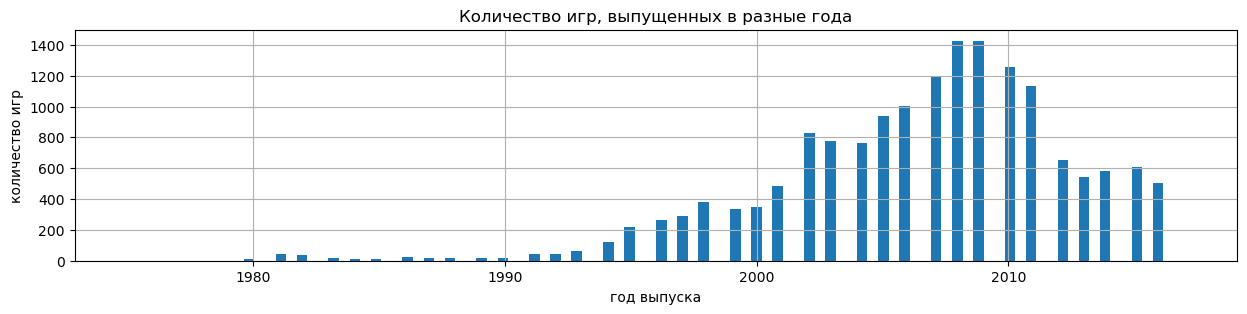

In [39]:
data_games.plot(y='year_of_release', kind='hist', bins=100, figsize = (15,3), grid=True, range=(1975,2017), legend=False,\
title='Количество игр, выпущенных в разные года')\
.set(xlabel='год выпуска', ylabel='количество игр');

In [40]:
data_games.query('year_of_release < 1995')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985,platform,29.08,3.58,6.81,0.77,tbd,tbd,RP,39.47
5,Tetris,GB,1989,puzzle,23.20,2.26,4.22,0.58,tbd,tbd,RP,29.68
9,Duck Hunt,NES,1984,shooter,26.93,0.63,0.28,0.47,tbd,tbd,RP,27.84
18,Super Mario World,SNES,1990,platform,12.78,3.75,3.54,0.55,tbd,tbd,RP,20.07
21,Super Mario Land,GB,1989,platform,10.83,2.71,4.18,0.42,tbd,tbd,RP,17.72
...,...,...,...,...,...,...,...,...,...,...,...,...
15551,Mortal Kombat,PC,1994,fighting,0.02,0.00,0.00,0.00,tbd,tbd,RP,0.02
15692,Empire Deluxe,PC,1992,strategy,0.02,0.00,0.00,0.00,tbd,tbd,RP,0.02
15788,World Class Rugby 2: Kokunai Gekitou Hen '93,SNES,1994,sports,0.00,0.00,0.02,0.00,tbd,tbd,RP,0.02
15957,Strongest Tokyo University Shogi DS,DS,1985,action,0.00,0.00,0.02,0.00,tbd,tbd,RP,0.02


<div style="border: solid pink 2px; padding: 20px">Распределение количества игр по годам выглядит нормальным, но растянутым влево. Количество игр, выпущенных ранее 1995 года всего 486. От общего количества игр это всего около 3%, хотя временной период составляет 15 лет, а общий изучаемый период - 36 лет. Учитывая, как сейчас быстро развивается игровая индустрия, и как относительно медленно она развивалась 30 лет назад, когда еще мало у кого были собственные компьютеры и приставки, данными за этот период можно принебречь. Самое большое количество игр было выпущенно в 2008-2009 годах.

### Изменение продаж по платформам и среднее время жизни платформы

#### Изменение продаж по платформам

In [41]:
platform_list_top = data_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(15).index 
# отсортированный по количеству продаж список платформ 

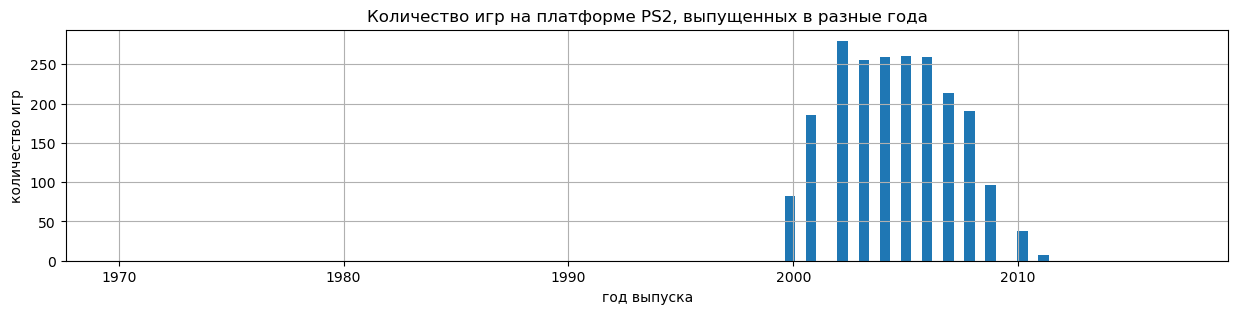

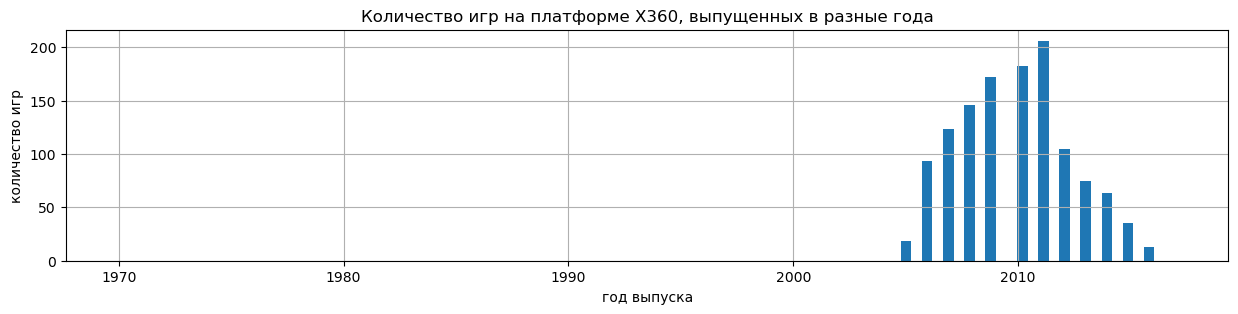

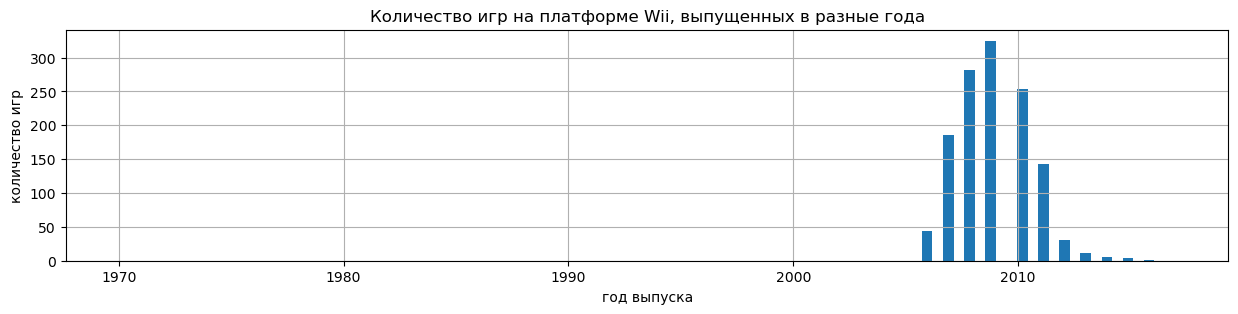

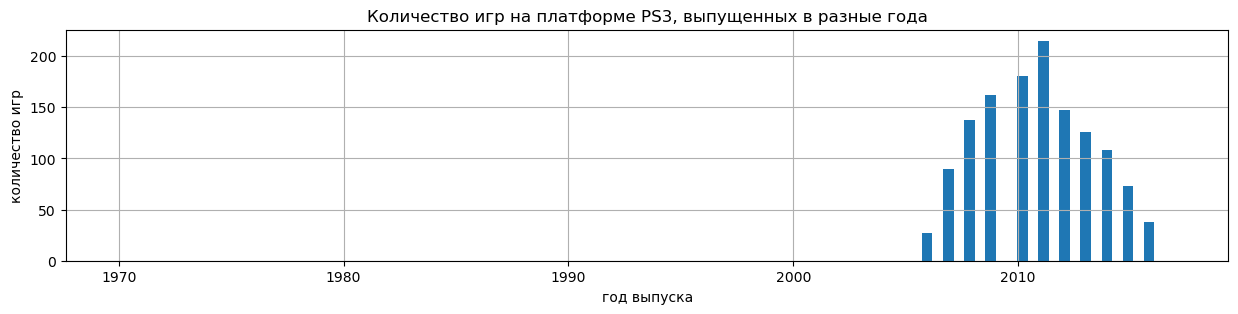

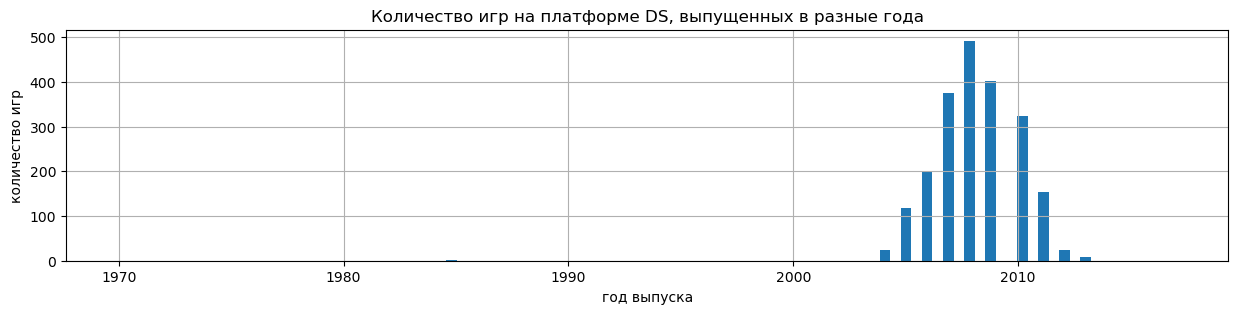

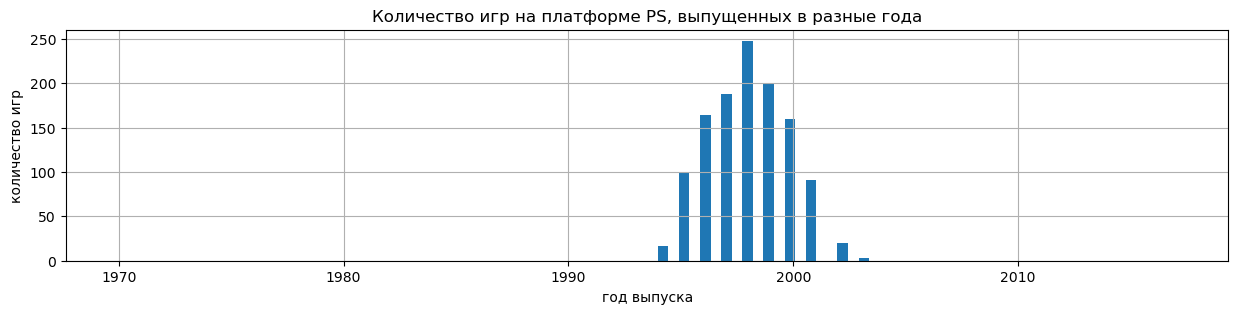

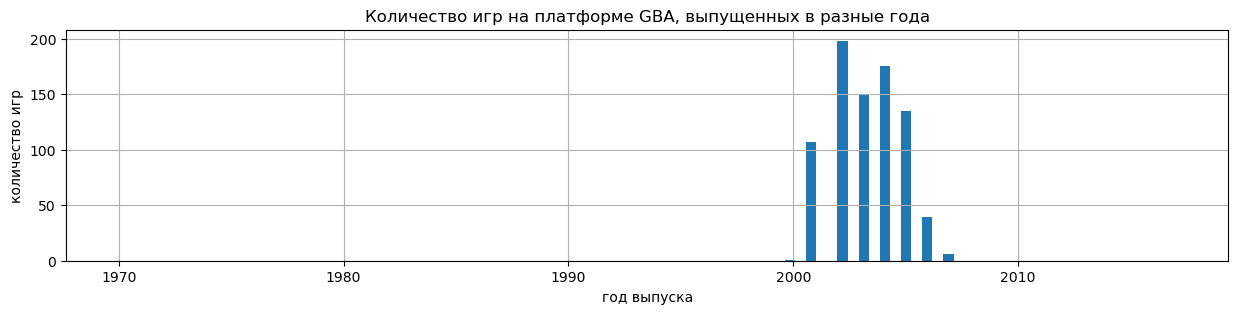

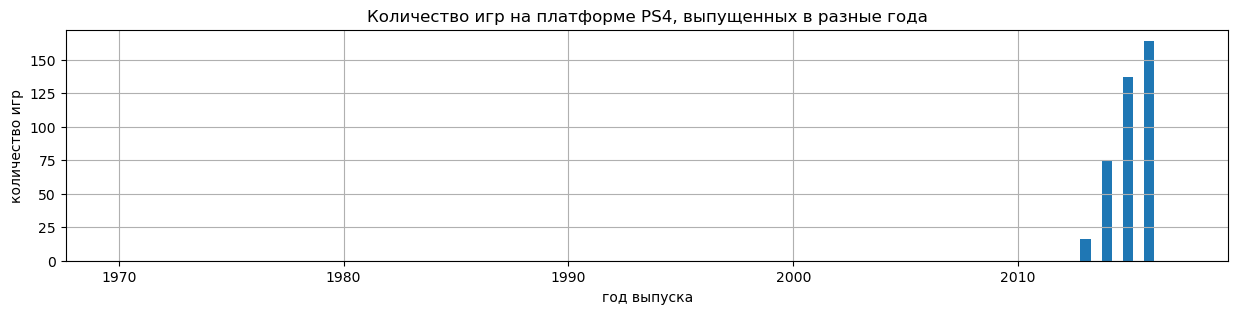

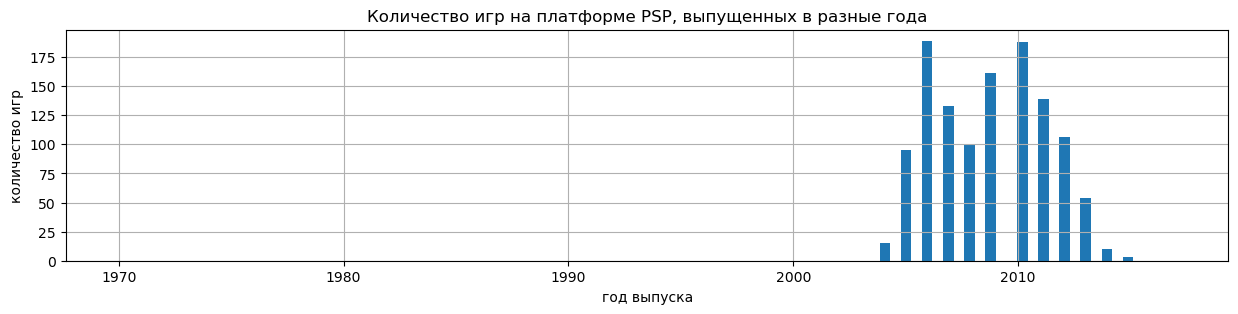

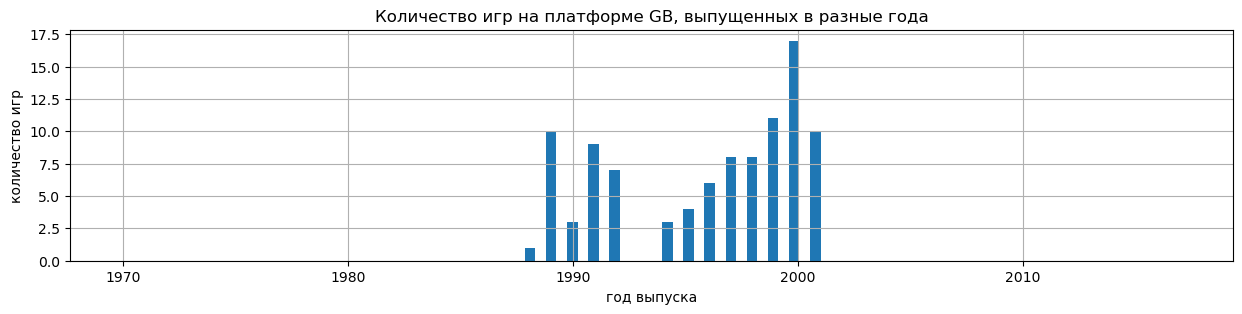

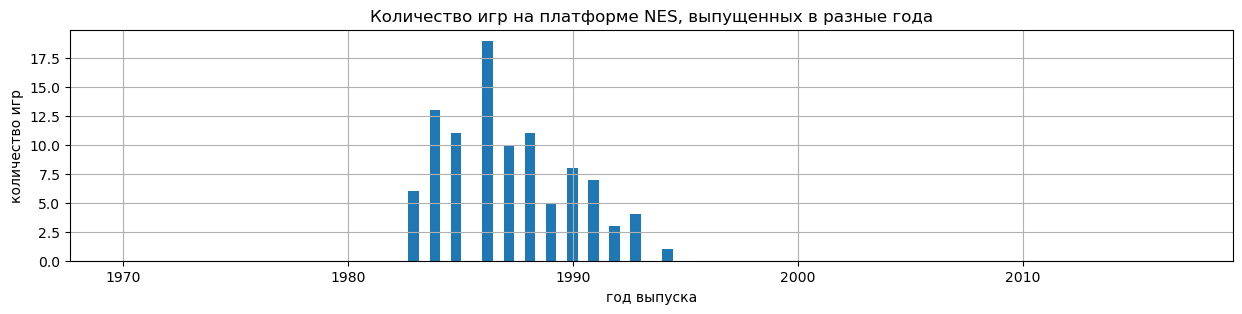

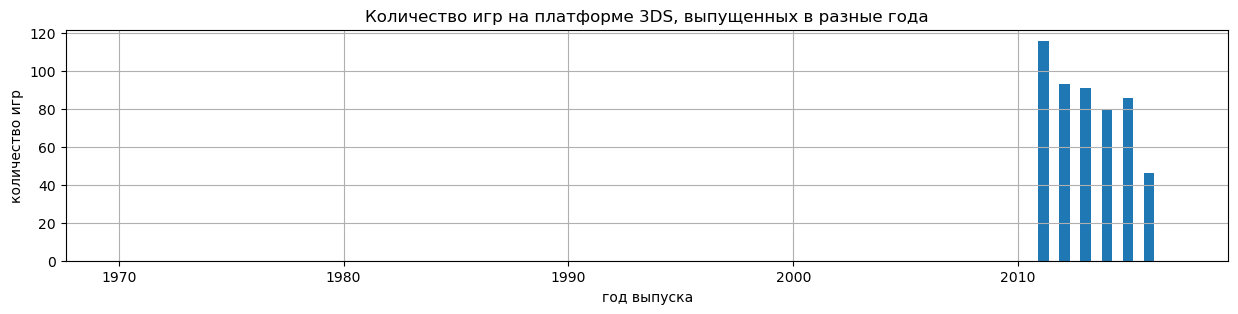

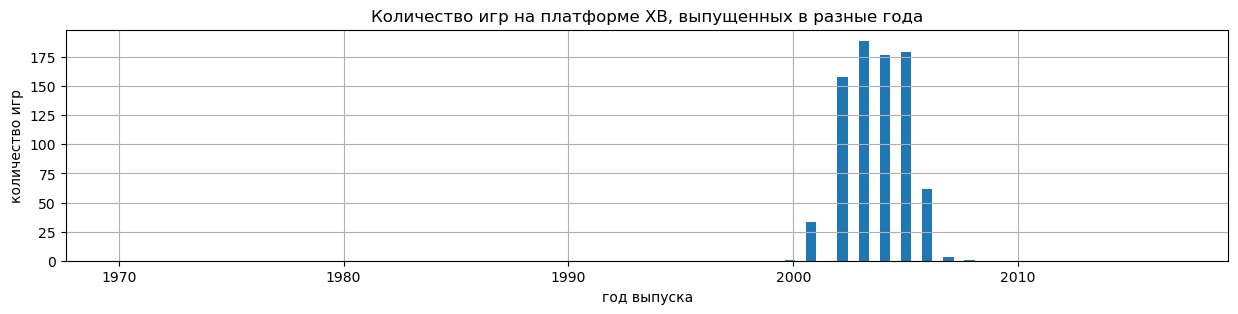

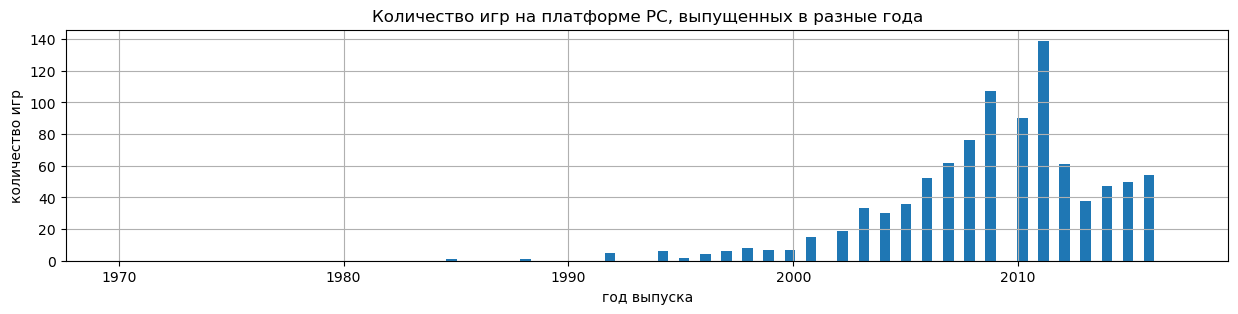

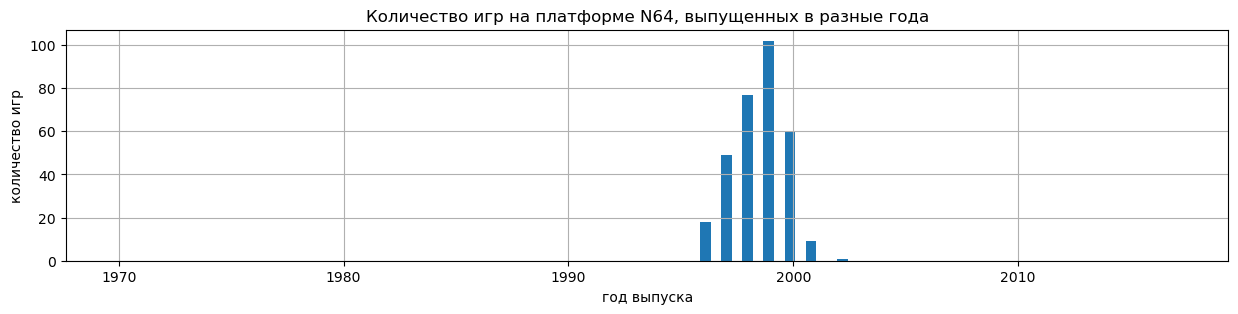

In [42]:
for platform in platform_list_top: # графики для каждой из платформы выше
    platform_data_games = data_games[data_games['platform']==platform]
    platform_data_games.plot(y='year_of_release', kind='hist', bins=100, figsize = (15,3), grid=True, range=(1970,2017), legend=False,\
title=f'Количество игр на платформе {platform}, выпущенных в разные года')\
.set(xlabel='год выпуска', ylabel='количество игр');

Выше видны распределение по количеству игр на самых продаваемых платформах.

<div style="border: solid pink 2px; padding: 20px">Больше всего продаж у игр на PS2 (1043.09 миллионов проданных копий), X360 (874.95 миллионов проданных копий), Wii (813.47 миллионов проданных копий), PS3 (794.42 миллионов проданных копий), DS (743.74 миллионов проданных копий), PS (686.89 миллионов проданных копий). Получается, что больше всего продаж у серии игровых консолей PlayStation.

#### Cреднее время жизни платформы

Посмотрим, сколько лет жила каждая платформа. Cоздади список всех платформ, соберем сводную таблицу, содержащую первый и последний год продаж на каждой платформе, затем по разности между ними найдем срок продаж.

In [43]:
platform_list_all = data_games.groupby('platform')['name'].count().sort_values(ascending=False).index  # cписок всех платформ

In [44]:
platform_years = data_games[data_games['platform'].isin(platform_list_all)]\
.pivot_table(index='platform', values='year_of_release', aggfunc={'min', 'max'}) # сводная таблица

In [45]:
platform_years['term'] = platform_years['max']-platform_years['min']

In [46]:
platform_years.head()

,max,min,term
platform,,,
2600,1989,1980,9
3DO,1995,1994,1
3DS,2016,2011,5
DC,2008,1998,10
DS,2013,1985,28


In [47]:
platform_years[platform_years['max']!=2016]['term'].median() # уберем те платформы, для которых игры все еще продаются

6.5

<div style="border: solid pink 2px; padding: 20px">Медианный срок жизни платформы - 6,5 лет.

### Актуализация данных

In [48]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16441 non-null  object 
 1   platform         16441 non-null  object 
 2   year_of_release  16441 non-null  int32  
 3   genre            16441 non-null  object 
 4   na_sales         16441 non-null  float64
 5   eu_sales         16441 non-null  float64
 6   jp_sales         16441 non-null  float64
 7   other_sales      16441 non-null  float64
 8   critic_score     16441 non-null  object 
 9   user_score       16441 non-null  object 
 10  rating           16441 non-null  object 
 11  total_sales      16441 non-null  float64
dtypes: float64(5), int32(1), object(6)
memory usage: 1.6+ MB


Исходя из 3.1, будем изучать данные за 2013-2016 года, то есть за 3 года. Исходя из 3.2, возьмем 15 самых продаваемых платформ.

In [49]:
data_games = data_games[data_games['year_of_release']>=2013]

In [50]:
platform_list_top = data_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index

In [51]:
platform_list_top

Index(['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP'], dtype='object', name='platform')

In [52]:
data_games = data_games.query('platform in @platform_list_top')

In [53]:
data_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,action,7.02,9.09,0.98,3.96,97,8.2,M,17.09
23,Grand Theft Auto V,X360,2013,action,9.66,5.14,0.06,1.41,97,8.1,M,14.86
31,Call of Duty: Black Ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,tbd,tbd,RP,12.25
33,Pokemon X/Pokemon Y,3DS,2013,role-playing,5.28,4.19,4.35,0.78,tbd,tbd,RP,13.82
42,Grand Theft Auto V,PS4,2014,action,3.96,6.31,0.38,1.97,97,8.3,M,10.65
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,adventure,0.00,0.00,0.01,0.00,tbd,tbd,RP,0.01
16707,Aiyoku no Eustia,PSV,2014,misc,0.00,0.00,0.01,0.00,tbd,tbd,RP,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,action,0.00,0.00,0.01,0.00,tbd,tbd,RP,0.01
16712,Haitaka no Psychedelica,PSV,2016,adventure,0.00,0.00,0.01,0.00,tbd,tbd,RP,0.01


В таблице осталось 2233 записей, содержание данные с 2013 года по 2016 и с 10 самыми продаваемыми платформами.

### Потенциально прибыльные платформы

In [54]:
top_platform_data_games = data_games.pivot_table(index={'platform','year_of_release'}, values='total_sales', aggfunc={sum}).reset_index()

In [55]:
top_platform_data_games.head()

,platform,year_of_release,sum
0,3DS,2013,53.97
1,3DS,2014,41.75
2,3DS,2015,26.75
3,3DS,2016,14.50
4,PC,2013,11.27


In [56]:
platform_list_top

Index(['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP'], dtype='object', name='platform')

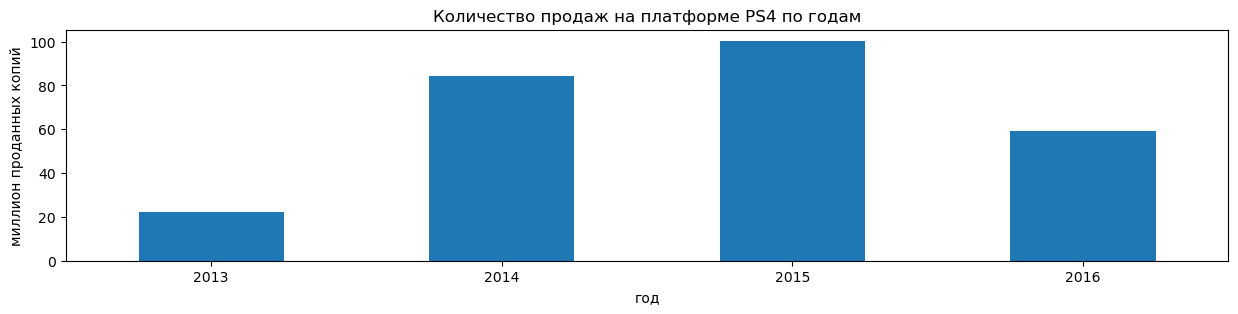

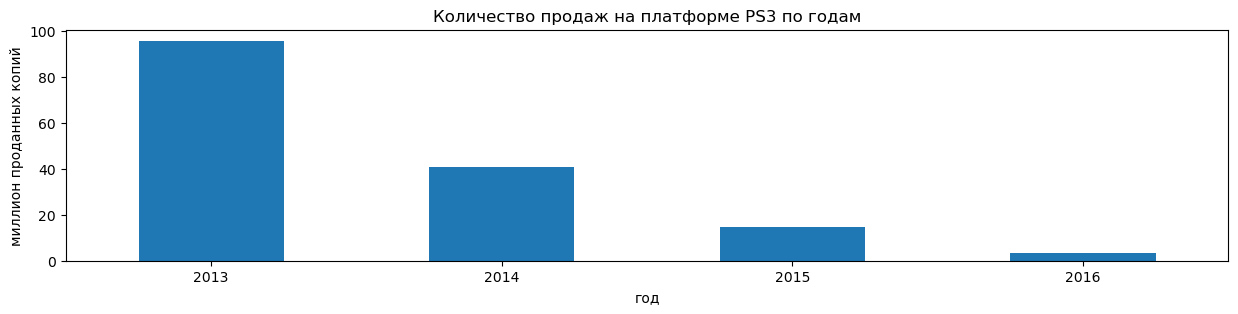

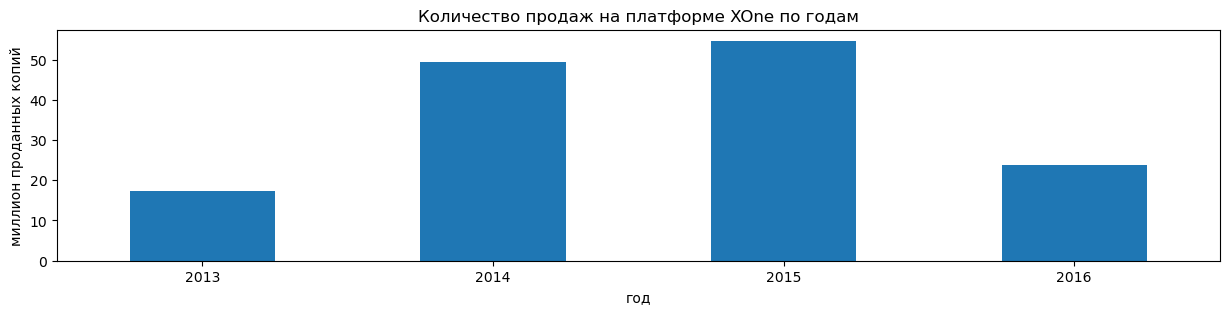

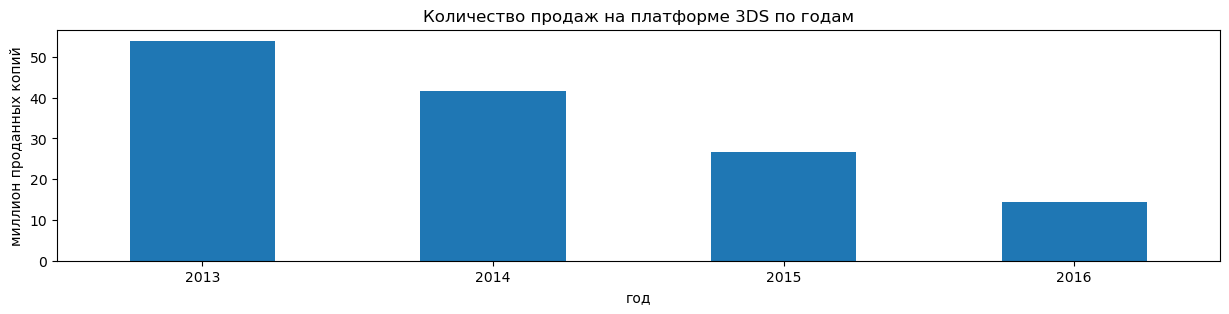

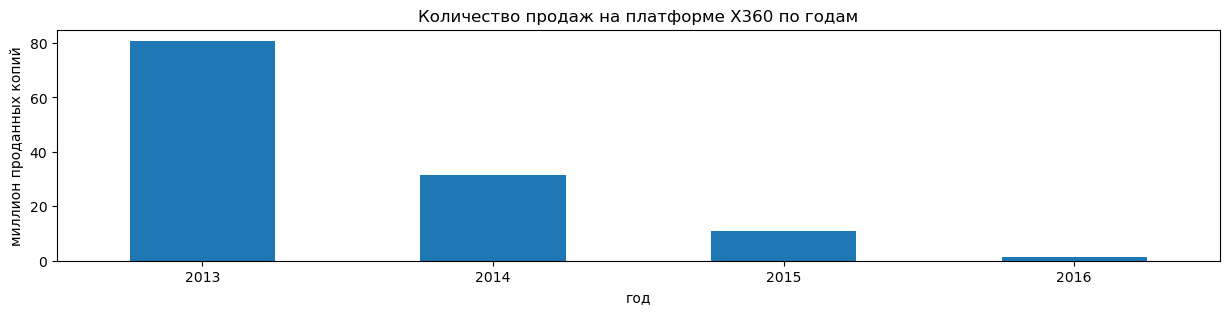

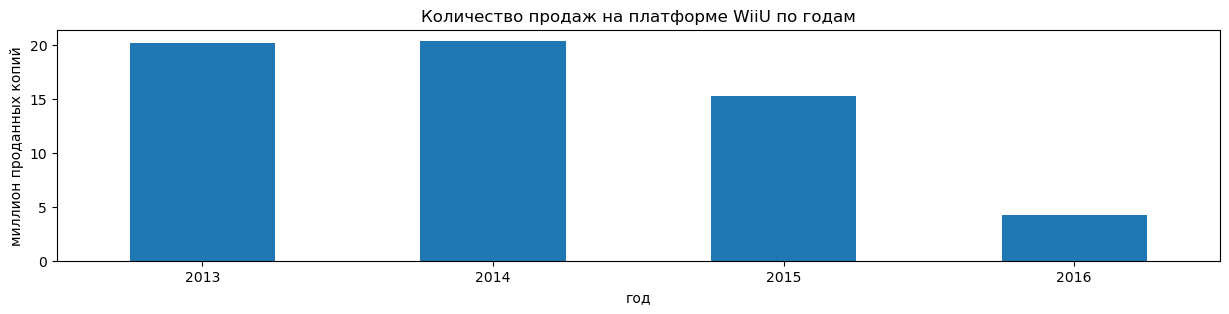

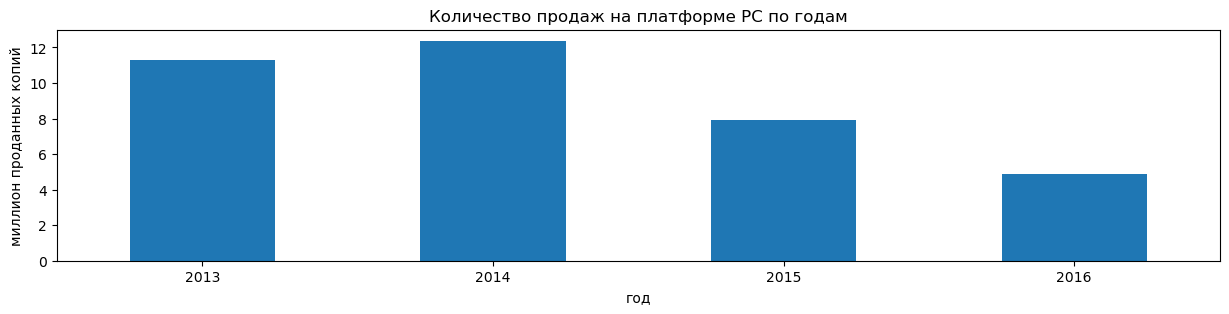

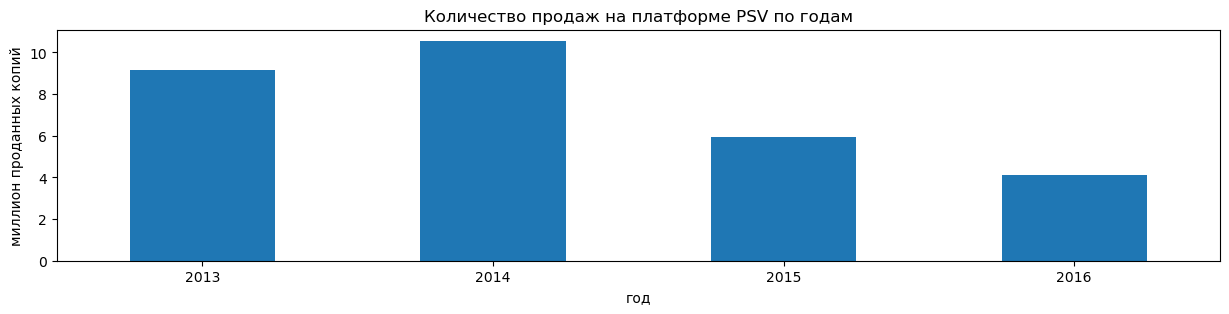

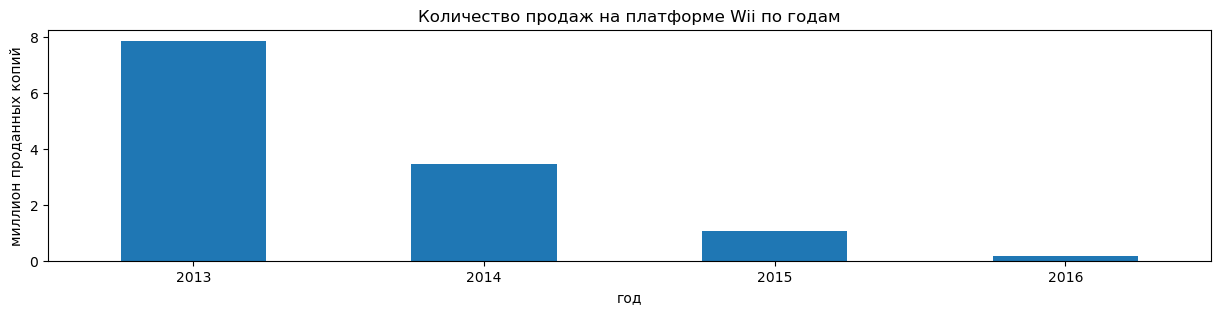

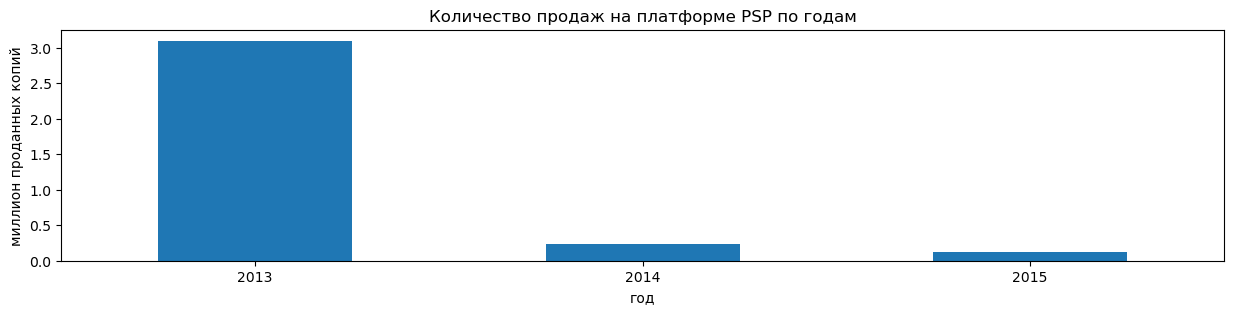

In [57]:
for platform in platform_list_top:
    data_games_platform = top_platform_data_games[top_platform_data_games['platform']==platform]
    data_games_platform.sort_values(by=['year_of_release']).plot(x='year_of_release', kind='bar', figsize=(15,3), rot=0, legend=False,\
title=f'Количество продаж на платформе {platform} по годам')\
.set(xlabel='год', ylabel='миллион проданных копий');

<div style="border: solid pink 2px; padding: 20px">Исходя из графиков потенциально прибыльными платформами по продажам по годам являются PS4, XOne, 3DS, PC и WiiU

### Глобальные продажи игр в разбивке по платформам

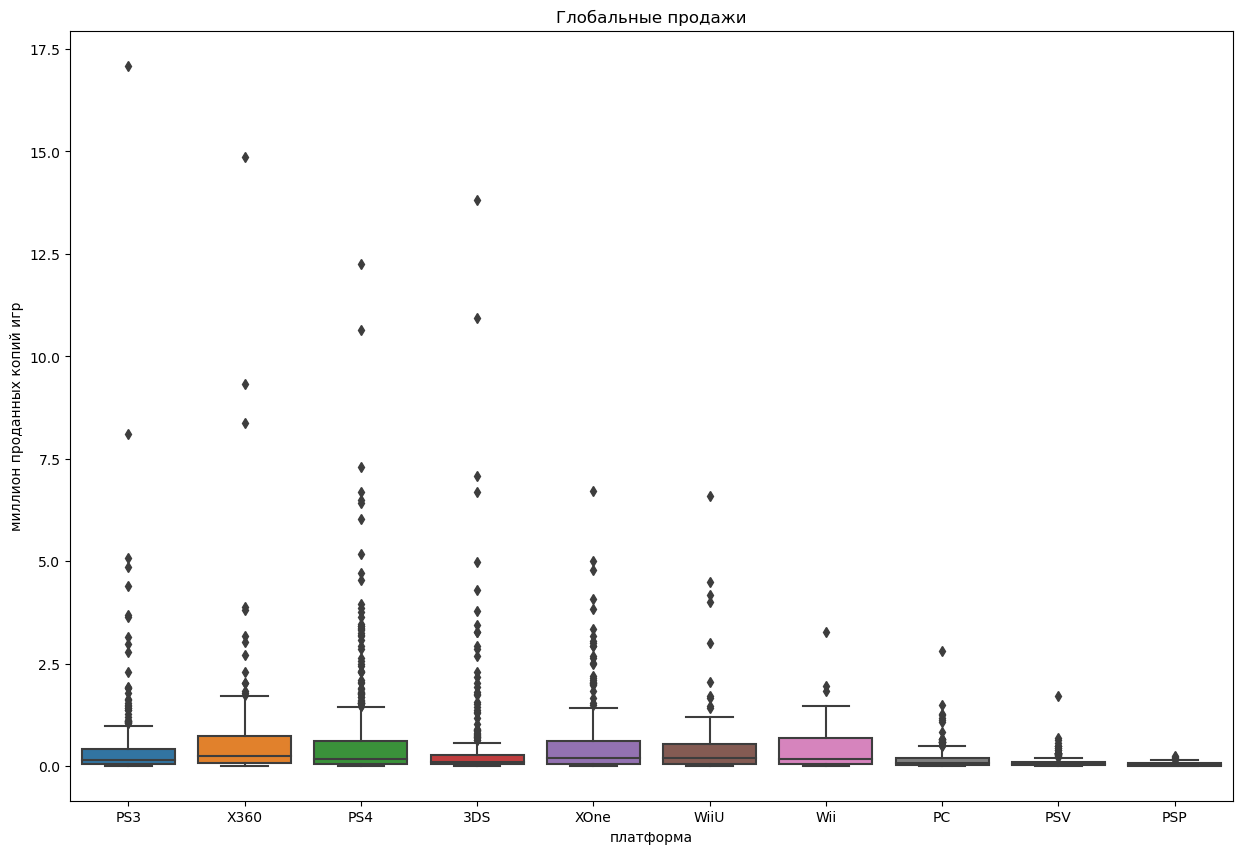

In [58]:
plt.figure(figsize=(15,10))
sns.boxplot(x='platform', y='total_sales', data=data_games)
plt.xlabel('платформа')
plt.ylabel("миллион проданных копий игр")
plt.title("Глобальные продажи");

Зададим диапазон оси с количеством проданных копий игр для лучшей визуализации графиков

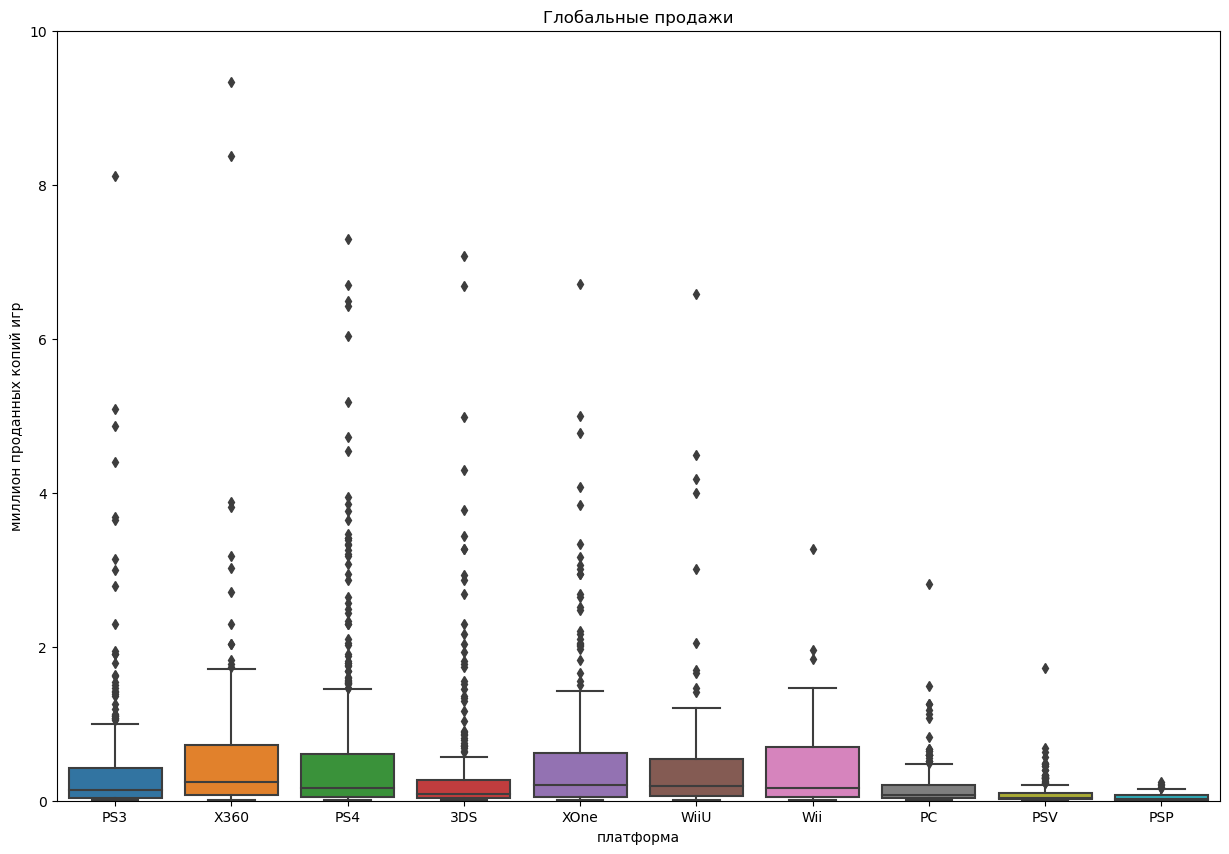

In [59]:
plt.figure(figsize=(15,10))
sns.boxplot(x='platform', y='total_sales', data=data_games)
plt.ylim([0, 10]) 
plt.xlabel('платформа')
plt.ylabel("миллион проданных копий игр")
plt.title("Глобальные продажи");

Для всех платформ медианное значение смещенно в сторону меньших значений, а значит и распределение также смещенно влево. Наибольшие медианные значения по количеству проданных копий игр имеют платформы X360, PS4, XOne, WiiU и Wii. Наиболее растянутая плотность распределения у платформ X360, PS4, XOne, WiiU и Wii что свидетельствует о большем разбросе продаж. Представляют интерес те платформы, имеющие самые длинные "усы", так как для них характерны большие продажи, а это X360, PS4, XOne, Wii. 

<div style="border: solid pink 2px; padding: 20px"> Исходя из всего этого, наиболее привлекательные платформы по глобальным продажам за все время - X360, PS4, XOne и WiiU.

### Влияние на продажи отзывов пользователей и критиков 

Рассмотрим самую продаваемую платформу PS4

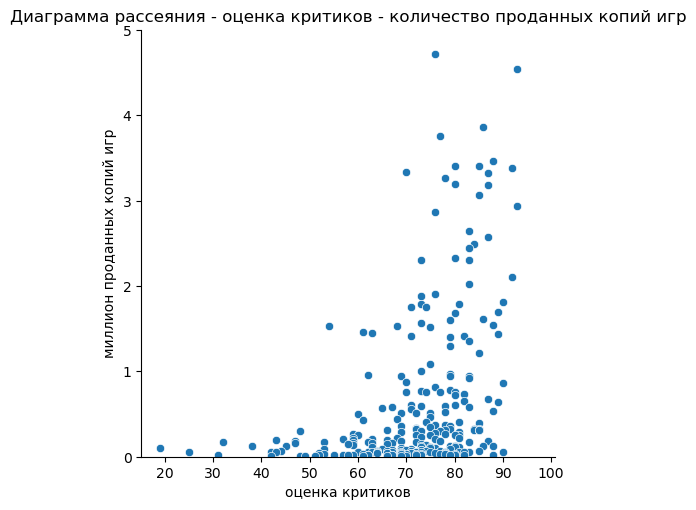

In [60]:
sns.relplot(data=data_games[data_games['platform']=="PS4"].\
            query('critic_score!="tbd"'), x='critic_score', y='total_sales', kind='scatter')
plt.ylim([0, 5])
plt.xlabel('оценка критиков')
plt.ylabel("миллион проданных копий игр")
plt.title("Диаграмма рассеяния - оценка критиков - количество проданных копий игр"); # 

In [61]:
data_games[data_games['platform']=="PS4"].query('critic_score!="tbd"')['critic_score'].astype(float).corr(data_games['total_sales'])

0.4058867746520127

Если исключить игры с оценкой tbd, то для консоли PS4 чем выше оценка критиков на старте продаж, тем больше будут глобальные продажи, хоть и коэффициент корреляции не самый большой (скорее всего из-за большинства не очень высоких продаж). Причем при оценках критиков от 70 до 90 (игр с оценкой 100 тут нет) продаж гораздо больше, на что стоит обратить внимание. Так же видно, что для большинства игр количество проданных копий около миллиона. 

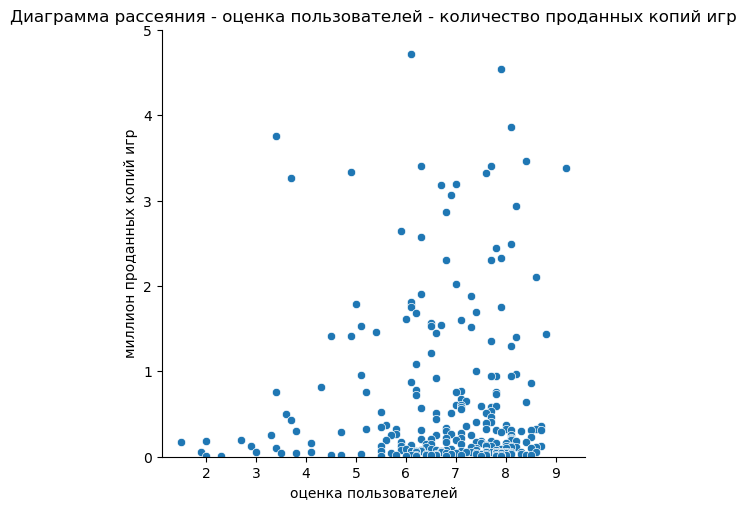

In [62]:
sns.relplot(data=data_games[data_games['platform']=="PS4"].\
            query('user_score!="tbd"'), x='user_score', y='total_sales', kind='scatter')
plt.ylim([0, 5])
plt.xlabel('оценка пользователей')
plt.ylabel("миллион проданных копий игр")
plt.title("Диаграмма рассеяния - оценка пользователей - количество проданных копий игр");

In [63]:
data_games[data_games['platform']=="PS4"].query('user_score!="tbd"')['user_score'].astype(float).corr(data_games['total_sales'])

-0.03126053686666918

С оценками пользователей ситуация немного другая. На графике видно, что у некоторых игр с высокими оценками пользователей продажи выше, чем у большинства, однако коэффициент корреляции показывает, что связи между этими двумя показателями для данной платформы нет. Вероятно, это потому что одни из первых пользователей при покупке игр опираются на мнение критиков, а следующие за ними покупатели смотрят и на оценку критиков, и на оценки пользователей, а ткак как мнение пользователей различно, что решение о покупке принимается скорее на основании других факторов

<div style="border: solid pink 2px; padding: 20px">Можно предположить, что на старте продаж сильнее влияет оценка критиков, а в дальнешьем - оценки пользователей и критиков.

Построим такие же диаграммы рассеяния еще для трех потенциально прибыльных платформ

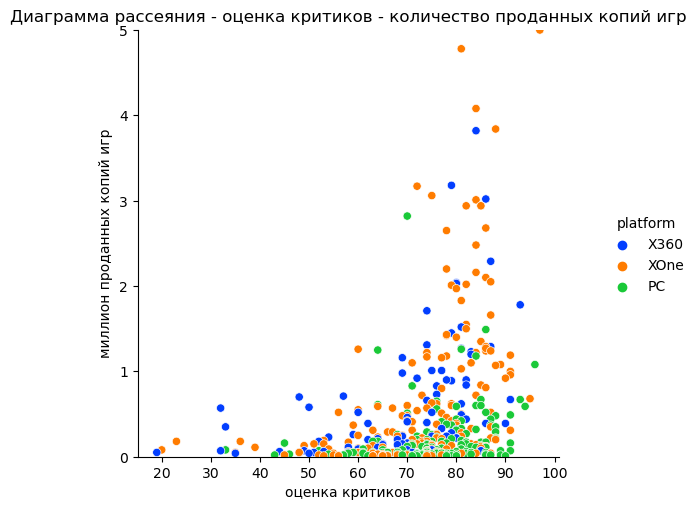

In [64]:
sns.relplot(data=data_games[(data_games['platform']=="XOne")|(data_games['platform']=="PC")|(data_games['platform']=="X360")]\
.query('critic_score!="tbd"'), x='critic_score', y='total_sales', kind='scatter', palette='bright', hue='platform')
plt.ylim([0, 5])
plt.xlabel('оценка критиков')
plt.ylabel("миллион проданных копий игр")
plt.title("Диаграмма рассеяния - оценка критиков - количество проданных копий игр");

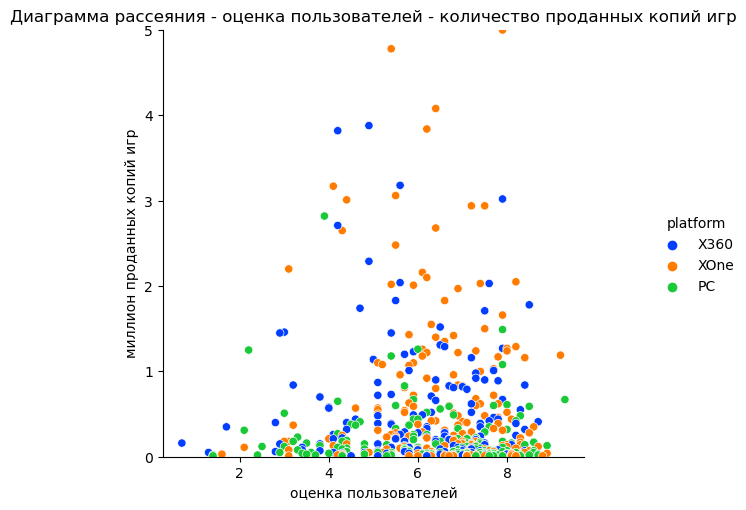

In [65]:
sns.relplot(data=data_games[(data_games['platform']=="XOne")|(data_games['platform']=="PC")|(data_games['platform']=="X360")].query('user_score!="tbd"'), x='user_score', y='total_sales', kind='scatter', palette='bright',
    hue='platform')
plt.ylim([0, 5])
plt.xlabel('оценка пользователей')
plt.ylabel("миллион проданных копий игр")
plt.title("Диаграмма рассеяния - оценка пользователей - количество проданных копий игр");

Вид диаграммы рассеяния для всех платформ очень схож между собой и с диаграммой рассеяния для платформы PS4. На диаграмме рассеяния - оценка пользователей - количество проданных копий игр связь между оценкой пользователей и продажами не видно, что скорее подтверждает теорию о том, что первые продажи происходят под влиянием оценок критиков, а дальше разочарованные или не очень пользователи ставят свои оценки и это мало как влияет на покупку.

### Распределение игр по жанрам

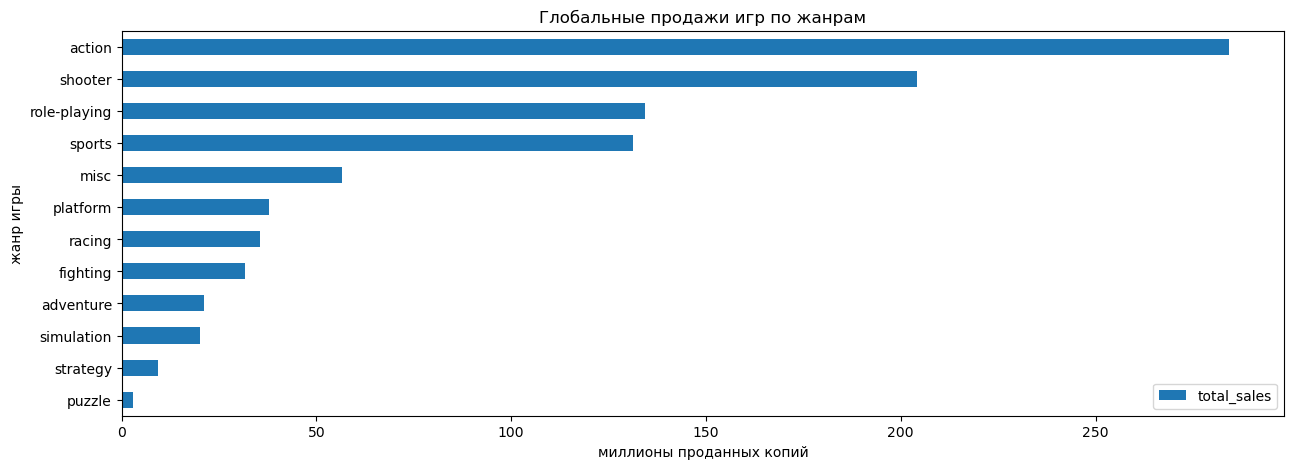

In [66]:
data_games.pivot_table(index='genre', values='total_sales', aggfunc='sum')\
.sort_values(by='total_sales', ascending = True)\
.plot(y='total_sales', kind='barh', figsize = (15,5), title='Глобальные продажи игр по жанрам')\
.set(xlabel='миллионы проданных копий', ylabel='жанр игры');

Видно, что лидирующую позицию по продажам занимает жанр action. Так же к прибыльным жанрам отнесем жанр shooter, role-playing и sports. Меньше всего продаются simulation, strategy и puzzle.

Хочется посмотреть продажи каждого жанра по годам

In [67]:
genre_data_games = data_games.pivot_table(index={'genre','year_of_release'}, values='total_sales', aggfunc={sum}).reset_index()

In [68]:
genre_data_games_list = genre_data_games['genre'].unique()

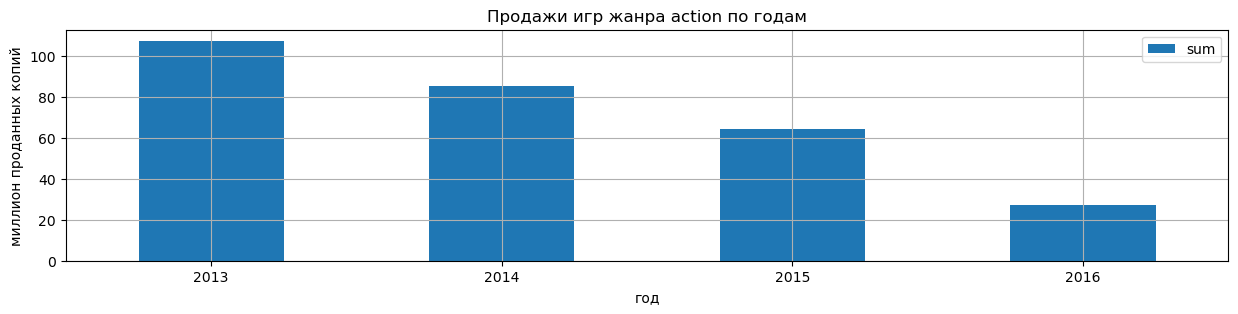

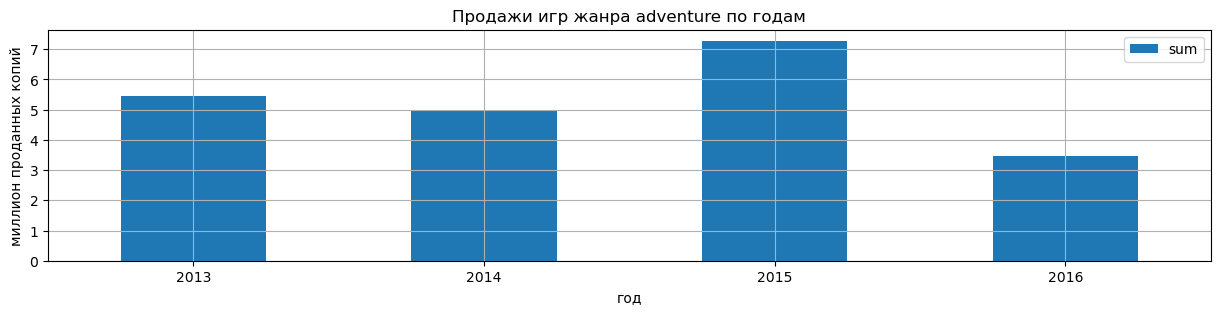

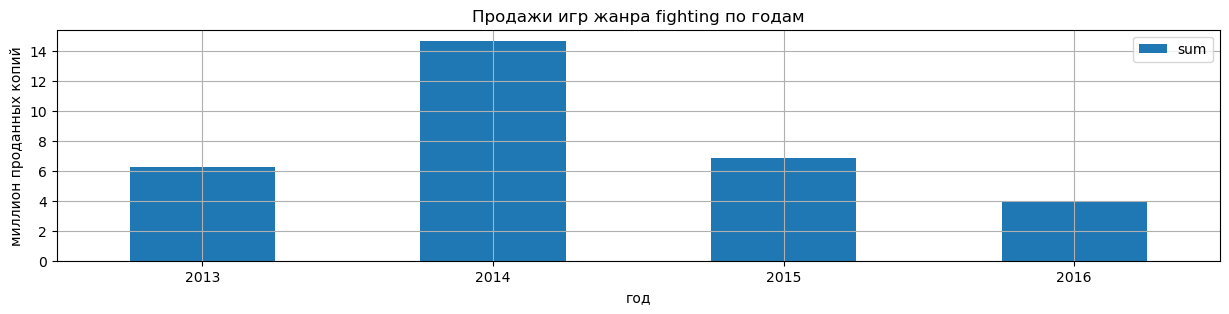

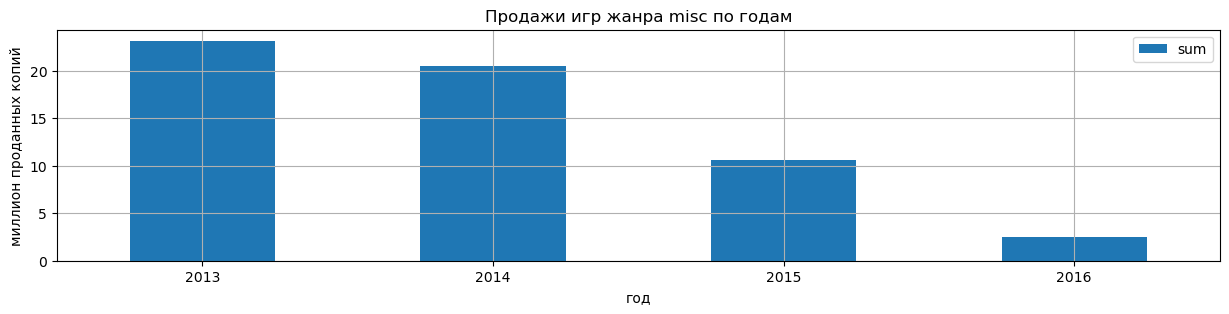

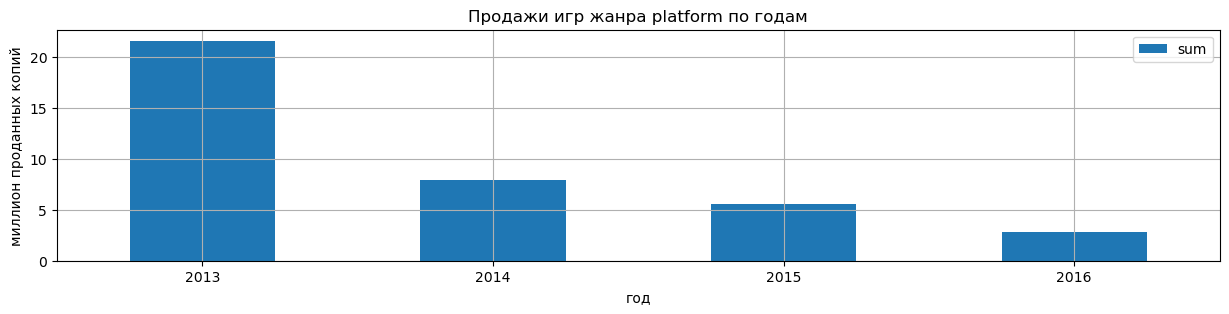

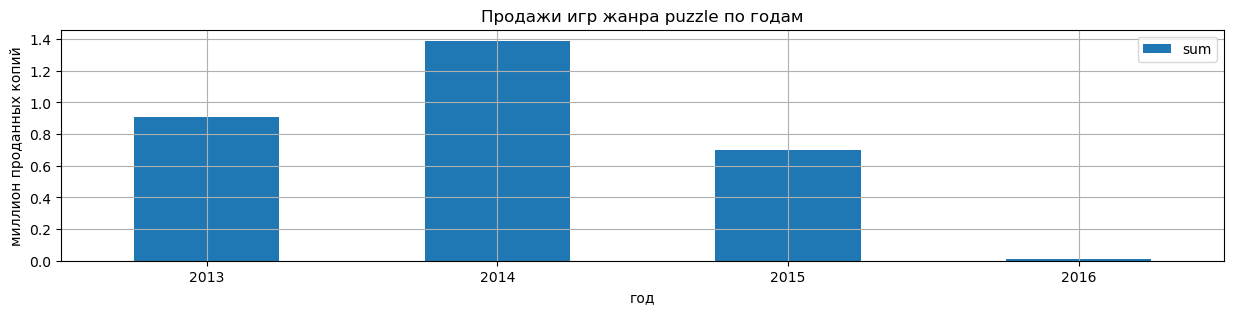

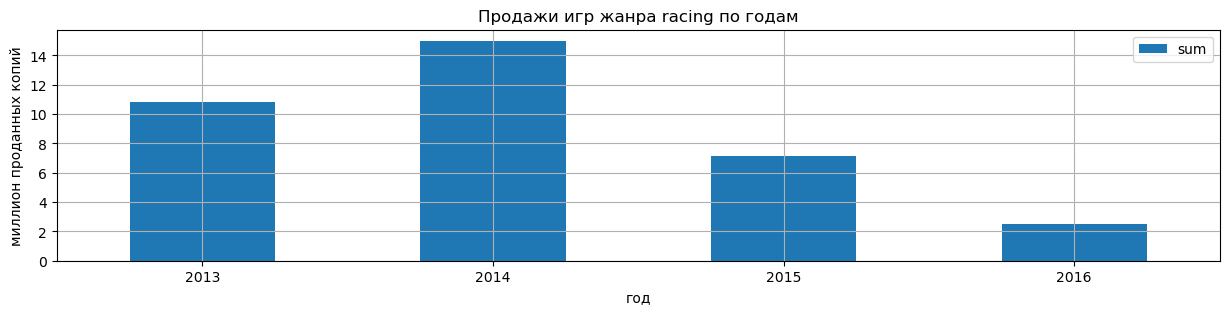

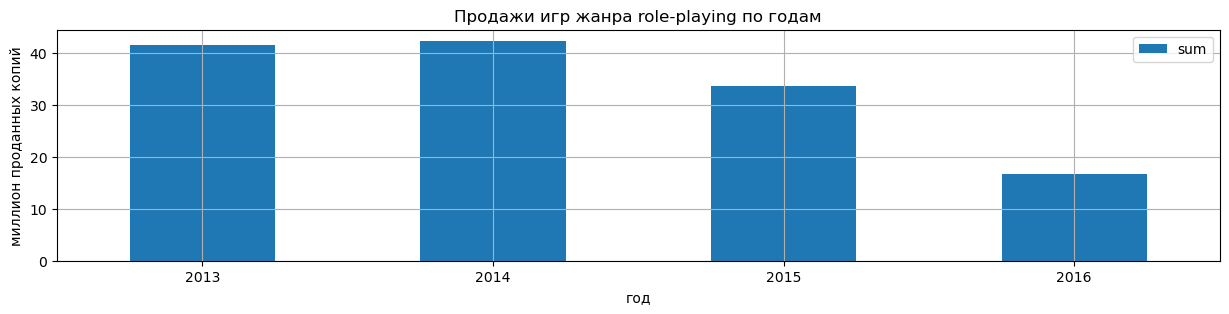

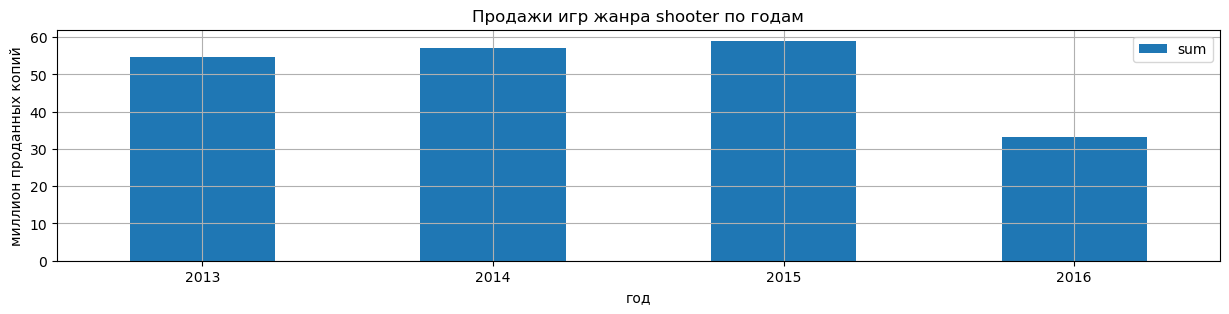

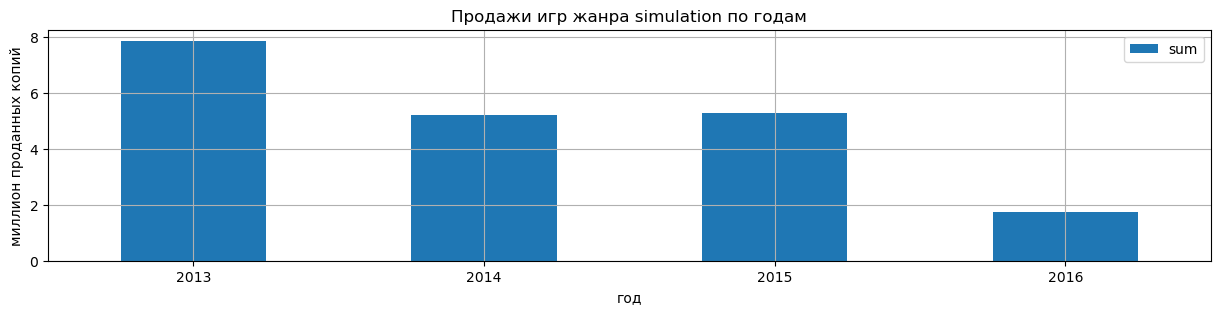

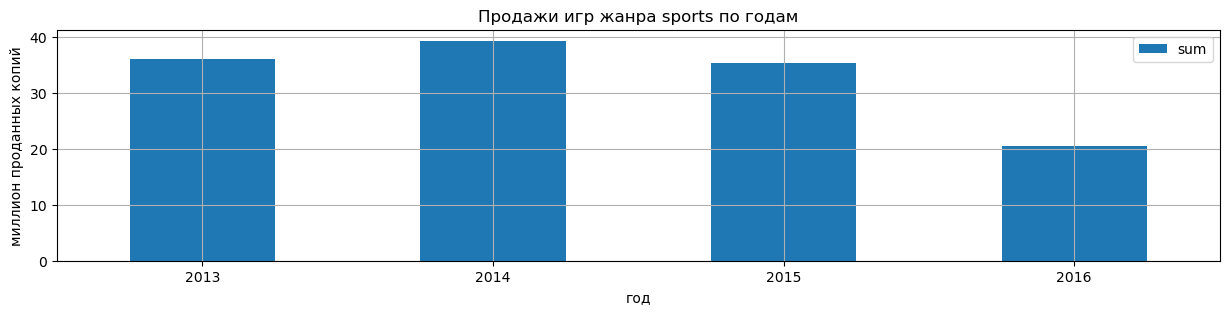

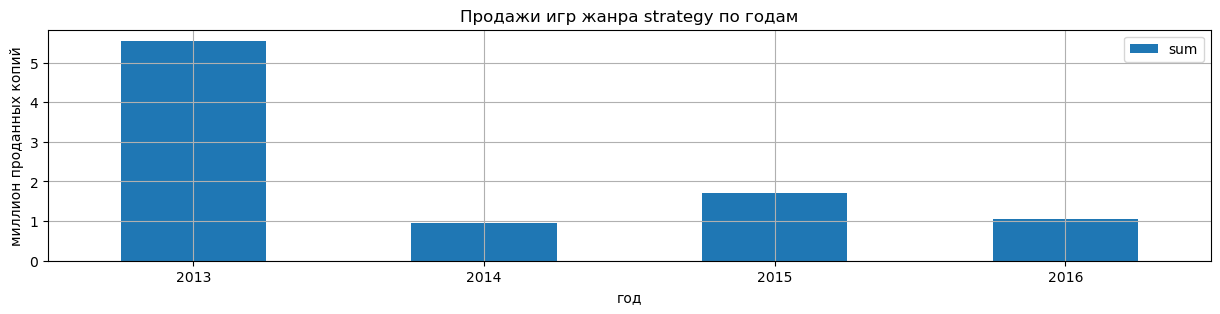

In [69]:
for g in genre_data_games_list:
    data_games_genre = genre_data_games[genre_data_games['genre']==g]
    data_games_genre.sort_values(by=['year_of_release']).plot(x='year_of_release', kind='bar', figsize=(15,3), grid=True, rot=0, legend=True,\
title=f'Продажи игр жанра {g} по годам').set(xlabel='год', ylabel='миллион проданных копий');

In [70]:
for g in genre_data_games_list:
    data_games_genre = data_games[data_games['genre']==g]
    #print(data_games_genre)
    total_sales_median = data_games_genre['total_sales'].mean()
    print(f'Для игр жанра {g} среднее значение глобальных продаж составляет {round(total_sales_median, 2)} миллионов проданных копий')

Для игр жанра action среднее значение глобальных продаж составляет 0.37 миллионов проданных копий
Для игр жанра adventure среднее значение глобальных продаж составляет 0.09 миллионов проданных копий
Для игр жанра fighting среднее значение глобальных продаж составляет 0.4 миллионов проданных копий
Для игр жанра misc среднее значение глобальных продаж составляет 0.37 миллионов проданных копий
Для игр жанра platform среднее значение глобальных продаж составляет 0.53 миллионов проданных копий
Для игр жанра puzzle среднее значение глобальных продаж составляет 0.18 миллионов проданных копий
Для игр жанра racing среднее значение глобальных продаж составляет 0.42 миллионов проданных копий
Для игр жанра role-playing среднее значение глобальных продаж составляет 0.46 миллионов проданных копий
Для игр жанра shooter среднее значение глобальных продаж составляет 1.09 миллионов проданных копий
Для игр жанра simulation среднее значение глобальных продаж составляет 0.33 миллионов проданных копий
Для и

Жанр action стал продаваться хуже, однако 20 миилионов проданных копий один из самых больших показателей для 2016 года, игры жанра sports так же продаются меньше, но так же имеют показатель около 20 миллионов проданных копий. Жанр shooter набрал и держит популярность в данный период, игры с таким жанром в 2016 году продались около 35 миллионов раз. Еще стоит обратить внимание на жанр role-playing, продажи в 2016 году почти достигли показателя в 20 миллионов.

Самое большое среднее значение глобальных продаж у жанра shooter.
  

**Общий вывод:**
<div style="border: solid pink 2px; padding: 20px">
Рассмотрены данные с 2013 по 2016 год и 10 самых продаваемых платформ. Самое большое количество игр было выпущенно в 2008-2009 годах. Больше всего продаж у игр на PS2, X360, Wii, PS3, DS, PS. Медианный срок жизни платформы - 6,5 лет. Потенциально прибыльными по количеству игр по годам являются платформы PS4, XOne, 3DS, PC и WiiU. Наиболее привлекательные платформы по количеству глобальных продаж - X360, PS4, XOne и WiiU. Можно предположить, что на старте продаж сильнее влияет оценка критиков, а в дальнешьем - оценки пользователей и критиков. Потенциально прибыльными жанрами игр являются <u>shooter</u>, action, sports, role-playing.

## Портрет пользователя из каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Самые популярные платформы (топ-5)

In [71]:
data_games_sales = data_games.pivot_table(index='platform', values={'na_sales','eu_sales','jp_sales', 'other_sales', 'total_sales'}, aggfunc={'sum'})

In [72]:
data_games_sales.columns = data_games_sales.columns.get_level_values(0) # уберем мультииндекс 

In [73]:
data_games_sales.reset_index(inplace=True)

In [74]:
data_games_sales.sort_values(by='eu_sales',ascending=False).head()

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
3,PS4,141.09,15.96,108.74,48.35,265.79
2,PS3,67.81,23.35,63.50,26.77,154.66
9,XOne,51.59,0.34,93.12,14.27,145.05
8,X360,42.52,0.51,81.66,12.11,124.69
0,3DS,30.96,67.81,38.20,6.28,136.97


Самые популярные платформы среди пользователей Европы по количеству проданных копий игр (в миллионах) это PS4 (141.09), PS3 (67.81), XOne (51.5), X360 (42.52) и 3DS (30.96).

In [75]:
data_games_sales.sort_values(by='jp_sales',ascending=False).head()

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
0,3DS,30.96,67.81,38.20,6.28,136.97
2,PS3,67.81,23.35,63.50,26.77,154.66
5,PSV,6.10,18.59,5.04,3.26,29.73
3,PS4,141.09,15.96,108.74,48.35,265.79
7,WiiU,19.85,10.88,29.21,4.69,59.94


Самые популярные платформы среди пользователей Японии по количеству проданных копий игр (в миллионах) это 3DS (67.81), PS3 (23.35), PSV (18.59), PS4 (15.96) и WiiU (10.88).

In [76]:
data_games_sales.sort_values(by='na_sales',ascending=False).head()

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
3,PS4,141.09,15.96,108.74,48.35,265.79
9,XOne,51.59,0.34,93.12,14.27,145.05
8,X360,42.52,0.51,81.66,12.11,124.69
2,PS3,67.81,23.35,63.50,26.77,154.66
0,3DS,30.96,67.81,38.20,6.28,136.97


Самые популярные платформы среди пользователей Северной Америки по количеству проданных копий игр (в миллионах) это PS4 (108.74), XOne (93.12), X360 (81.66), PS3 (63.50), 3DS (38.20). 

Построим круговые диаграммы продаж на всех самых популярных для каждого региона платформах

In [77]:
region_list = ['eu_sales','jp_sales','na_sales'] # список регионов

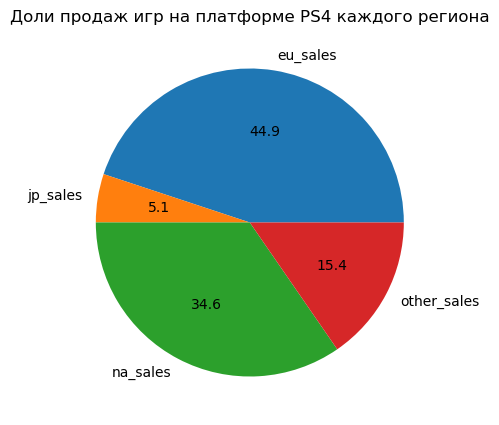

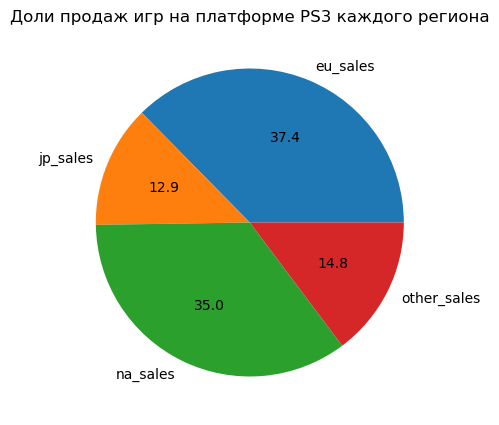

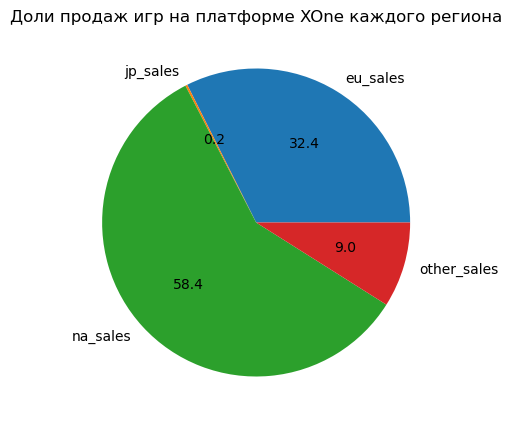

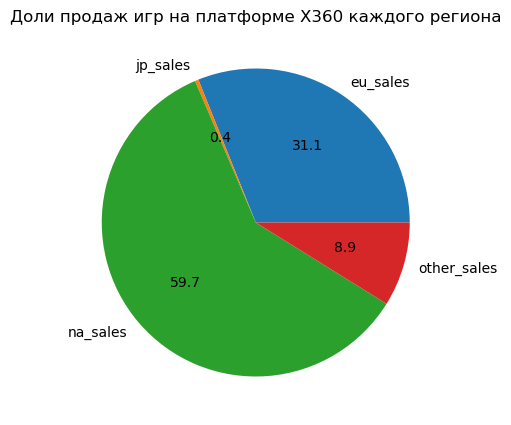

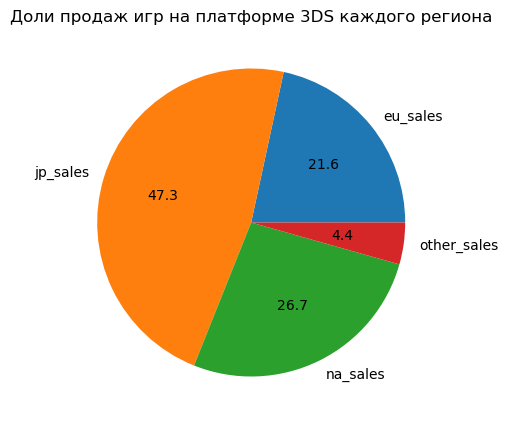

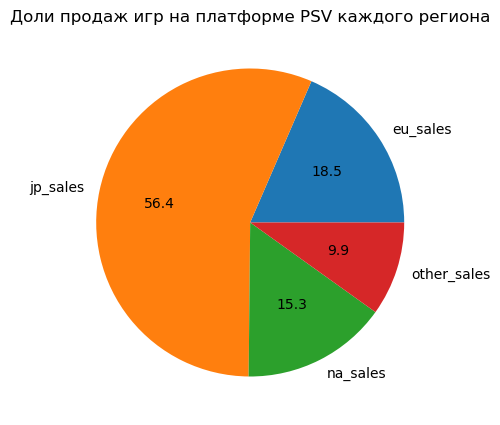

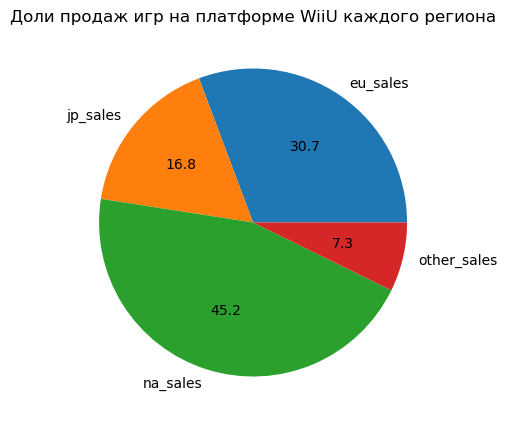

In [78]:
list_of_platform = [] # лист с платформами, для которых уже построен график
for region in region_list: # берем каждый регион
    region_data = data_games_sales.sort_values(by=region,ascending=False).head() # строим для него таблицу, как выше
    region_data = region_data.transpose() # делаем удобную таблицу для круговой диаграммы
    region_data.columns = list(data_games_sales.sort_values(by=region,ascending=False).head()['platform'])
    region_data = region_data[1:5]   
    # для каждой платформы из топ-5  каждого региона строим график, но только если он не был построен до этого
    for p in list(data_games_sales.sort_values(by=region,ascending=False).head()['platform']):  
        if p not in list_of_platform:
            region_data.plot(y=p, kind='pie', autopct='%.1f', figsize = (15,5), title=f'Доли продаж игр на платформе {p} каждого региона', legend=False)\
.set(ylabel='');
            list_of_platform.append(p)

Для Европы самые популярные платформы это PS4 и PS3, для Северной Америки это XOne, X360 и WiiU, для Японии - 3DS, PSV. Северная Америка занимает около 60% от всех продаж игр для платформы X360 и XOne, что объясняется тем, что сама серия игровых консолей Xbox выпускается американской транснациональной корпорацией Microsoft. А для платформ Nintendo (3DS) видно, что значительную долю продаж занимает японский регион, что тоже скорее всего связанно с японским происхождением компании. Самый большой показатель продаж для европейского региона у платформы PS4, которая выпускается Sony Interactive Entertainment, которая является дочерней компанией Sony Group Corporation, которая так же является японской транснациональной корпорацией. 

### Самые популярные жанры (топ-5)

In [79]:
data_games_genre = data_games.pivot_table(index='genre', values={'na_sales','eu_sales','jp_sales', 'other_sales', 'total_sales'}, aggfunc={'sum'})

In [80]:
data_games_genre

,eu_sales,jp_sales,na_sales,other_sales,total_sales
,sum,sum,sum,sum,sum
genre,,,,,
action,117.89,40.49,125.83,37.16,284.21
adventure,8.22,5.82,7.14,2.43,21.18
fighting,8.55,7.65,15.55,3.56,31.75
misc,20.00,9.20,27.46,6.08,56.66
platform,15.15,4.79,17.93,4.07,37.87
puzzle,1.00,1.18,0.83,0.16,3.01
racing,20.19,2.30,12.96,4.44,35.45
role-playing,36.97,51.04,46.40,11.48,134.41


In [81]:
data_games_genre.columns = data_games_genre .columns.get_level_values(0) # уберем мультииндекс 

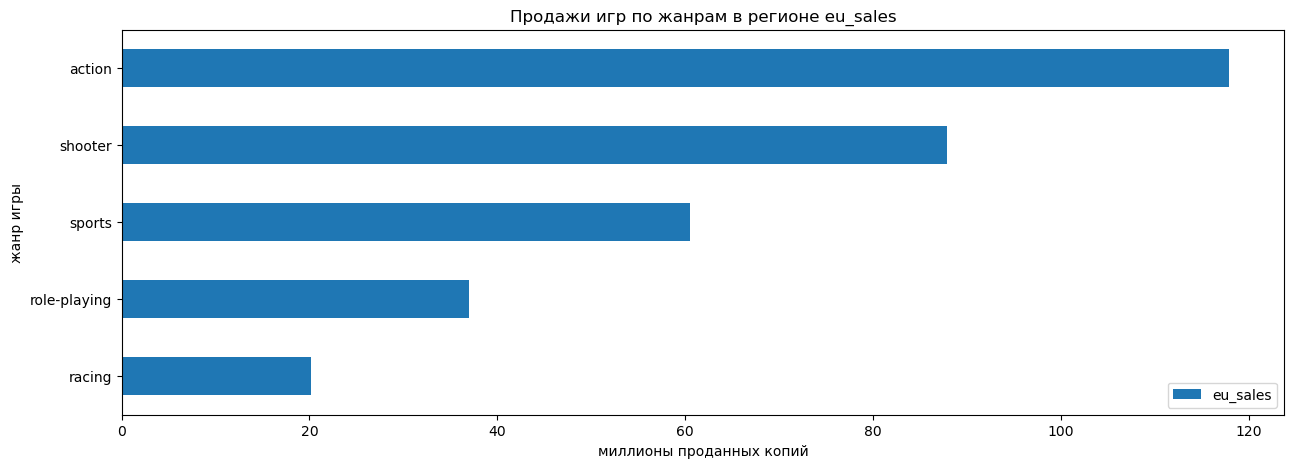

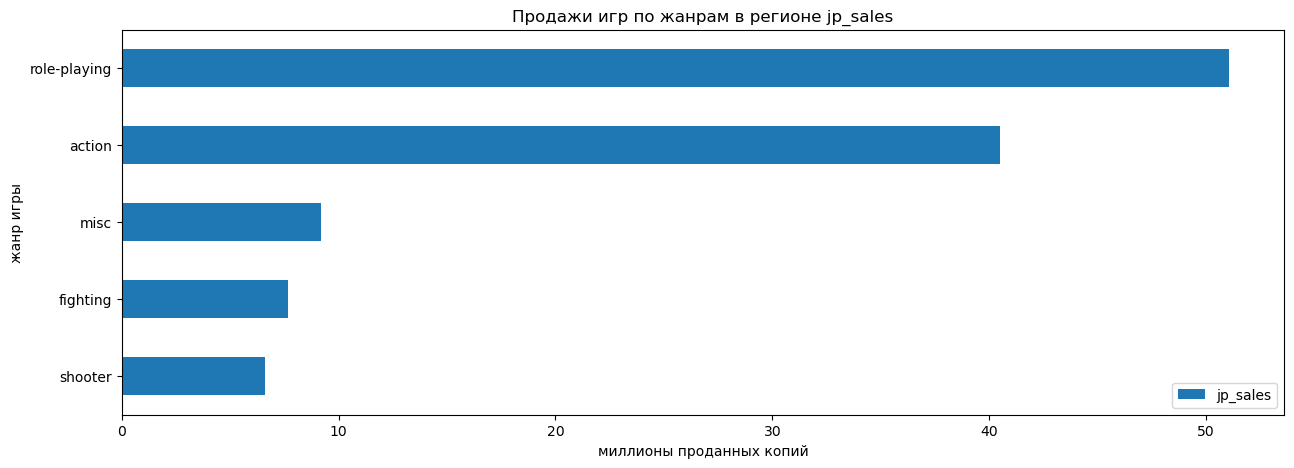

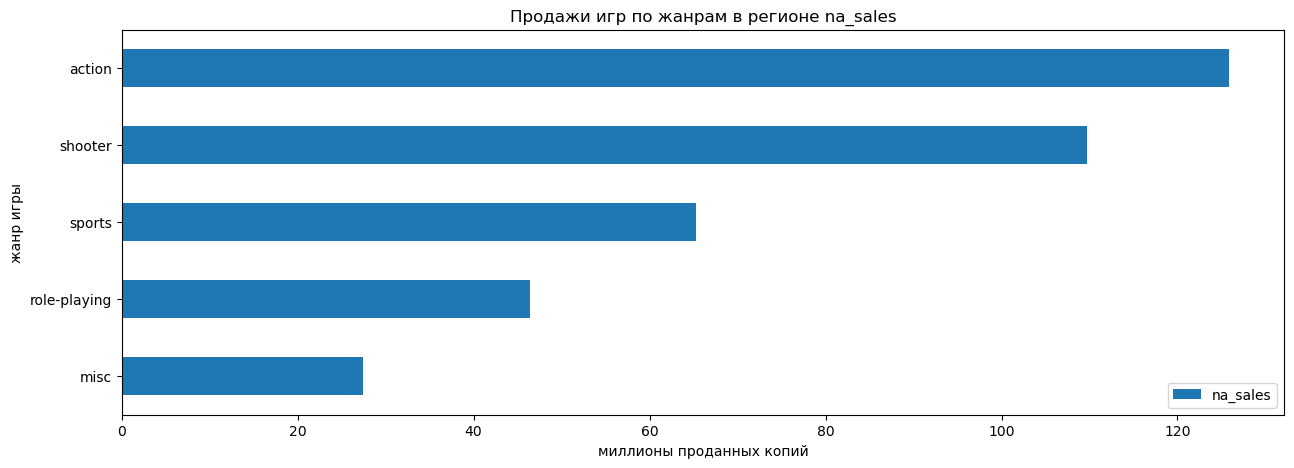

In [82]:
for region in region_list: # берем каждый регион
    region_data = data_games_genre.sort_values(by=region,ascending=True).tail(5)
    region_data.plot(y=region, kind='barh', figsize = (15,5), title=f'Продажи игр по жанрам в регионе {region}')\
.set(xlabel='миллионы проданных копий', ylabel='жанр игры');

Для Европы самые популярные жанры игры action (117.89), shooter (87.86), sports (60.49), role-playing(36.97), racing (20.19) по количеству проданных копий игр (в миллионах).
Для Японии самые популярные жанры игры role-playing (51.04), action (40.49), misc (9.20), fighting (7.65), shooter (6.61) по количеству проданных копий игр (в миллионах).
Для Серверной Америки самые популярные жанры игры action (125.83), shooter (109.74), sports (65.27), role-playing (46.40), misc (27.46) по количеству проданных копий игр (в миллионах).

### Влияние ESRB на продажи

In [83]:
data_games_ESRB = data_games.pivot_table(index='rating', values={'na_sales','eu_sales','jp_sales', 'other_sales', 'total_sales'}, aggfunc={'sum'})

In [84]:
data_games_ESRB.columns = data_games_ESRB.columns.get_level_values(0)

In [85]:
data_games_ESRB.sort_values(by='eu_sales',ascending=False)

,eu_sales,jp_sales,na_sales,other_sales,total_sales
rating,,,,,
M,145.32,14.11,165.21,47.04,324.64
E,82.97,15.14,78.94,22.57,177.05
RP,78.61,85.05,89.18,23.41,252.84
E10+,42.53,5.89,54.02,12.54,102.44
T,41.95,20.59,49.79,14.29,112.33


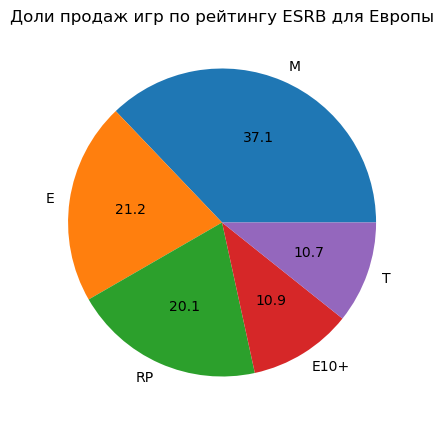

In [86]:
data_games_ESRB.sort_values(by='eu_sales',ascending=False).head().plot(y='eu_sales', kind='pie', autopct='%.1f', figsize = (15,5), title=f'Доли продаж игр по рейтингу ESRB для Европы', legend=False)\
.set(ylabel='');

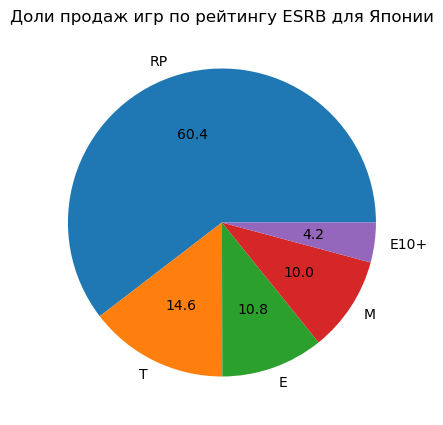

In [87]:
data_games_ESRB.sort_values(by='jp_sales',ascending=False).head().plot(y='jp_sales', kind='pie', autopct='%.1f', figsize = (15,5), title=f'Доли продаж игр по рейтингу ESRB для Японии', legend=False)\
.set(ylabel='');

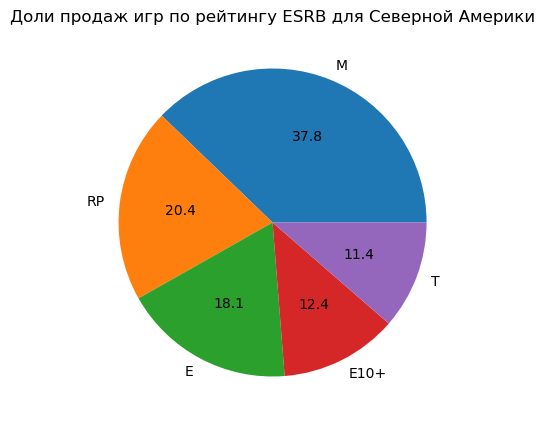

In [88]:
data_games_ESRB.sort_values(by='na_sales',ascending=False).head().plot(y='na_sales', kind='pie', autopct='%.1f', figsize = (15,5), title=f'Доли продаж игр по рейтингу ESRB для Северной Америки', legend=False)\
.set(ylabel='');

Графики выглядят похожими для Европы и Северной Америки, где больше всего было продано игр с рейтингом M, затем идут игры, для которых рейтинг пока еще не назначен (скорее всего это влияние замены пропусков на 'RP'), а затем идут игры с рейтингом E, E10+ и T. Для Японии больше половины проданных игр не имеет рейтинга. Вероятнее всего потому, что для Японии, как уже выяснено, наиболее продаваемые платформы принадлежат японским корпорациям, которые, в свою очередь, больше ориентируются на свой рынок, со своими оценками, и возможно, часть этих игр не признает оценку ESRB и имеет какую то свою. В остальном же распределение продаж игр по рейтингам T, E, M, E10+.

<div style="border: solid pink 2px; padding: 20px">
Типичный пользователь из Европы чаще играет на таких платформах серии PlayStation, в игры жанра action, sports и shooter. Для пользователя из Северной Америки платформа для игры это PS4 и серия Xbox, играть он предпочитает в игры тех же жанров, что и пользователь Европы. Они оба больше предпочитают рейтинг M. Пользователь из Японии играет на платформах серии PlayStation и Nintendo (3DS) в игры жанра role-playing, action и musc и рейтингом Т.

## Проверка гипотез


### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Cформулируем гипотезы

0. Нулевая гипотеза: средний пользовательские рейтинг игр платформы XOne равен среднему пользовательскому рейтингу игр платформы PC
1. Альтернативная гипотеза: средний пользовательские рейтинг игр платформы XOne не равен среднему пользовательскому рейтингу игр платформы PC

In [89]:
data_games_XOne = data_games[data_games['platform']=="XOne"].query('user_score!="tbd"')

In [90]:
data_games_XOne['user_score'] = data_games_XOne['user_score'].astype(float)

In [91]:
data_games_XOne['user_score'].count() # количество элементов в выборке

182

In [92]:
data_games_PC = data_games[data_games['platform']=="PC"].query('user_score!="tbd"')

In [93]:
data_games_PC['user_score'] = data_games_PC['user_score'].astype(float)

In [94]:
data_games_PC['user_score'].count() # количество элементов в выборке

155

In [95]:
alpha = 0.05 
results5_1 = st.ttest_ind(data_games_XOne['user_score'], data_games_PC['user_score'], alternative='two-sided')

print('p-значение:', results5_1.pvalue)

if results5_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.14012658403611647
Не отвергаем нулевую гипотезу


<div style="border: solid pink 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средний пользовательский рейтинг игр платформы XOne равен среднему пользовательскому рейтингу игр платформы PC <b>не отвергнута</b>.

### Средние пользовательские рейтинги жанров Action и Sports разные

Cформулируем гипотезы

0. Нулевая гипотеза: средний пользовательский рейтинг игр жанра action равен среднему пользовательскому рейтингу игр жанра sports
1. Альтернативная гипотеза: средний пользовательский рейтинг игр жанра action не равен среднему пользовательскому рейтингу игр жанра sports

In [96]:
data_games_action = data_games[data_games['genre']=="action"].query('user_score!="tbd"')

In [97]:
data_games_action['user_score'] = data_games_action['user_score'].astype(float)

In [98]:
data_games_action['user_score'].count()

388

In [99]:
data_games_sports = data_games[data_games['genre']=="sports"].query('user_score!="tbd"')

In [100]:
data_games_sports['user_score'] = data_games_sports['user_score'].astype(float)

In [101]:
data_games_sports['user_score'].count()

160

In [102]:
alpha = 0.05 
results5_2 = st.ttest_ind(data_games_action['user_score'], data_games_sports['user_score'], equal_var=False, alternative='two-sided')

print('p-значение:', results5_2.pvalue)

if results5_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.1330204667098058e-20
Отвергаем нулевую гипотезу


<div style="border: solid pink 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средний пользовательский рейтинг игр жанра action равен среднему пользовательскому рейтингу игр жанра sports <b>отвергнута</b>, а <u>альтернативная гипотеза</u> о том, что редний пользовательский рейтинг игр жанра action не равен среднему пользовательскому рейтингу игр жанра sports <b>принимается верной<b>.

## Общий вывод

<div style="border: solid pink 2px; padding: 20px">
    
1. В таблице большинство пропусков в столбцах с оценками от критиков и пользователей, а так же с возрастным рейтингом.
    
2. Рассмотрены данные с 2013 по 2016 год и 15 самых продаваемых платформ:

    - Самое большое количество игр было выпущенно в 2008-2009 годах. 
    - Больше всего продаж у игр на PS2 (1043.09 миллионов проданных копий), X360 (874.95 миллионов проданных копий), Wii (813.47 миллионов проданных копий), PS3 (794.42 миллионов проданных копий), DS (743.74 миллионов проданных копий), PS (686.89 миллионов проданных копий). 
    - Медианный срок жизни платформы - 6,5 лет. 
    - Потенциально прибыльными по количеству игр в год являются платформы PS4, XOne, 3DS, PC и WiiU, по количеству глобальных продаж - X360, PS4, XOne и WiiU, прибыльными жанрами игр являются shooter, action, sports, role-playing.
    
    
3. Региональные различия:     
    - Самые популярные платформы среди пользователей Европы по количеству проданных копий игр (в миллионах) это PS4 (141.09), PS3 (67.81), XOne (51.5), среди пользователей Японии это DS (67.81), PS3 (23.35), PSV (18.59), и среди пользователей Северной Америки это PS4 (108.74), XOne (93.12), X360 (81.66). 
    - Для Европы самые популярные жанры игры action (117.89), shooter (87.86), sports (60.49) по количеству проданных копий игр (в миллионах), для Японии - role-playing (51.04), action (40.49), misc (9.20), для Серверной Америки action (125.83), shooter (109.74), sports (65.27).
    - Пользователи из Европы и Северной Америки больше предпочитают игры с возрастным рейтингом M «Для взрослых», а пользователи из Японии - T «Подросткам».
    
    
4. Проверка гипотез показала:    
    - У игр на платформах Xbox и PC одинаковый пользовательский рейтинг.
    - Нет оснований полагать, что пользовательские рейтинги игр жанра action и sports одинаковые


5. Рекомендации:
    - Сделать ставку на игры на платформах PlayStation и Xbox жанра shooter, action, sports, role-playing рейтингом М.